# NLP project - HaDeSpee Evalita 2020 challenge

Authors:
* Francesca Boccardi, francesca.boccardi@studio.unibo.it
* Luigi Podda, luigi.podda@studio.unibo.it

**Summary**: The purpose of this work is to address the
Hate Speech detection and the Stereotype detection tasks, towards a given people target, on the HaSpeeDe dataset of EvalIta, by experimenting
several combinations of word representation methods and architectures.

The EvalIta 2020 challenge is described at the following [link](http://www.di.unito.it/~tutreeb/haspeede-evalita20/index.html).



# Install & imports

In this section are installed and imported all the useful libraries and packages.

In [ ]:
%%capture
!pip install --upgrade numpy
!pip install compress-fasttext
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install autocorrect
!pip install pattern

After installing packages, it is necessary to restart the colab runtime to correctly import `compress-fasttext`.

In [ ]:
try:
  import compress_fasttext
except (ValueError):
  ## code to install gem
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

Stopping RUNTIME. Colaboratory will restart automatically. Please run again.


In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
import evaluate
import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs

import keras
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, Embedding, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras import backend as K

import tensorflow
from tensorflow.compat import v1

import pattern
from pattern.text.it import parse

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from autocorrect import Speller

import compress_fasttext

import itertools

import random
import torch
import os

from transformers import AutoModel, AutoTokenizer, DistilBertForSequenceClassification, AutoConfig
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The `set_reproducibility` function allows to make data pipeline reproducible and to train and evaluate the models using multiple and fixed seeds.

In [ ]:
def set_reproducibility(seed):

  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  tensorflow.random.set_seed(seed)
  tensorflow.keras.utils.set_random_seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)

# Data

## Data download

The EvalIta 2020 dataset is available for download at the following [link](https://github.com/msang/haspeede/tree/master/2020).  
To extract the data from the compressed folder the needed password
is *zNw3tCszKWcpDahq*.

In [ ]:
df_train = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Hate speech detection dataset/haspeede2_dev/haspeede2_dev_taskAB.tsv')
df_test_tweets = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Hate speech detection dataset/haspeede2_reference/haspeede2_reference_taskAB-tweets.tsv', header = None)
df_test_news = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Hate speech detection dataset/haspeede2_reference/haspeede2_reference_taskAB-news.tsv')

In [ ]:
df_train.columns = ['id', 'text', 'hate_speech', 'stereotype']
df_test_news.columns = ['id', 'text', 'hate_speech', 'stereotype']
df_test_tweets.columns = ['id', 'text', 'hate_speech', 'stereotype']

Let's have a look at the data.

In [ ]:
df_train

,id,text,hate_speech,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0
...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0
6833,9121,Il ministro dell'interno della Germania #Horst...,0,0
6834,8549,#Salvini: In Italia troppi si sono montati la ...,0,0
6835,9240,@user @user Chi giubila in buona fede non ha c...,0,0


In [ ]:
print('df_train:', df_train.shape)
print('df_test_news:', df_test_news.shape)
print('df_test_tweets:', df_test_tweets.shape)

df_train: (6837, 4)
df_test_news: (499, 4)
df_test_tweets: (1263, 4)


## Data inspection

In this section the data are inspected by printing some samples of hate speech and stereotype language, for both tweets and news.

In [ ]:
print("Tweet without hate speech and without stereotypes:")
print(df_test_tweets[(df_test_tweets['hate_speech'] == 0) & (df_test_tweets['stereotype'] == 0)]['text'].reset_index(drop=True)[0])

print("\nTweet without hate speech and with stereotypes:")
print(df_test_tweets[(df_test_tweets['hate_speech'] == 0) & (df_test_tweets['stereotype'] == 1)]['text'].reset_index(drop=True)[0])

print("\nTweet with hate speech and without stereotypes:")
print(df_test_tweets[(df_test_tweets['hate_speech'] == 1) & (df_test_tweets['stereotype'] == 0)]['text'].reset_index(drop=True)[0])

print("\nTweet with hate speech and with stereotypes:")
print(df_test_tweets[(df_test_tweets['hate_speech'] == 1) & (df_test_tweets['stereotype'] == 1)]['text'].reset_index(drop=True)[0])

Tweet without hate speech and without stereotypes:
Solo in #Italia dopo anni siamo ancora sotto assedio da parte di una becera #informazione collusa con i #mercenari della #politica. Dopo le flag sul #terrorismo ora siamo tornati al tema ossessivo sui #migranti con "film" h24 #iostoconterremotati URL

Tweet without hate speech and with stereotypes:
Sopralluogo al campo #rom di Via Martirano di #Milano: per la sinistra doveva diventare il campo più bell'Europa. Spese centinaia di migliaia di euro per le casette, i rom avrebbe dovuto pagare dei canoni per viverci. Risultato: degrado assoluto, delinquenti e merce rubata! URL

Tweet with hate speech and without stereotypes:
@user A me pare una scelta politica suicida puntare tutto su una battaglia sicuramente perdente in favore dell'immigrazione incontrollata...Meglio così, spariranno più velocemente!

Tweet with hate speech and with stereotypes:
@user e' un perfetto musulmano!!! chi dice il contrario mente, applica alla lettera la sura "l

In [ ]:
print("News without hate speech and without stereotypes:")
print(df_test_news[(df_test_news['hate_speech'] == 0) & (df_test_news['stereotype'] == 0)]['text'].reset_index(drop=True)[0])

print("\nNews without hate speech and with stereotypes:")
print(df_test_news[(df_test_news['hate_speech'] == 0) & (df_test_news['stereotype'] == 1)]['text'].reset_index(drop=True)[0])

print("\nNews with hate speech and without stereotypes:")
print(df_test_news[(df_test_news['hate_speech'] == 1) & (df_test_news['stereotype'] == 0)]['text'].reset_index(drop=True)[0])

print("\nNews with hate speech and with stereotypes:")
print(df_test_news[(df_test_news['hate_speech'] == 1) & (df_test_news['stereotype'] == 1)]['text'].reset_index(drop=True)[0])

News without hate speech and without stereotypes:
Sea Watch 3 di fronte a Malta, migrante si butta in acqua per disperazione. Trattativa per l'accoglienza

News without hate speech and with stereotypes:
Ritira la pensione, fa elemosina a una nomade e va al bar: dalle tasche gli spariscono 1000 euro

News with hate speech and without stereotypes:
Perché non voglio immigrati, cosa sarebbe l'Italia senza di loro: Sallusti, una durissima verità

News with hate speech and with stereotypes:
Che fine spero che faccia il killer nigeriano di Pamela. La furia cieca della Meloni: le sue parole più dure


In order to better understand the content of tweets and news, a text analysis is performed.

In [ ]:
def text_analysis(df):

  user = []
  hashtag = []
  url = []
  emoticon = []

  for sentence in df['text']:
    user = user + re.findall('@[A-Za-z0-9_]+', sentence)
    hashtag = hashtag + re.findall('#[A-Za-z0-9_]\w*', sentence)
    url = url + re.findall('\sURL', sentence)
    emoticon = emoticon + re.findall(r"[^\w\s,;.:!?%&€#/()@'\"“”\+-_|‘’…»«–—\*`$~°„]", sentence)

  return user, hashtag, url, emoticon

In [ ]:
### Train ###

user_train, hashtag_train, url_train, emoticon_train =  text_analysis(df_train)

print("\nThe total number of HASHTAGS appearing in the train tweets is", len(hashtag_train))
print("The number of unique HASHTAGS appearing in the train tweets is", len(set(hashtag_train)))
print("\nUnique HASHTAGS:")
print(set(hashtag_train),'\n')
print('-'*1000)

print("\nThe total number of EMOTICONS appearing in the train tweets is", len(emoticon_train))
print("The number of unique EMOTICONS appearing in the train tweets is", len(set(emoticon_train)))
print("\nUnique EMOTICONS:")
print(set(emoticon_train),'\n')
print('-'*1000)

print("\nThe total number of USERNAMES appearing in the train tweets is", len(user_train))
print("The number of unique USERNAMES appearing in the train tweets is", len(set(user_train)))
print("\nUnique USERNAMES:")
print(set(user_train), '\n')
print('-'*1000)

print("\nThe total number of URLs appearing in the train tweets is", len(url_train))
print("The number of unique URLs appearing in the train tweets is", len(set(url_train)))
print("\nUnique URLs:")
print(set(url_train))


The total number of HASHTAGS appearing in the train tweets is 4980
The number of unique HASHTAGS appearing in the train tweets is 2166

Unique HASHTAGS:
{'#SeQuestoÈunMinistro', '#roma', '#adessobastaaa', '#giustizia', '#COMMERCIANTI', '#brigaterosse', '#il', '#noterrorismo', '#SanPietroburgo', '#periferie', '#ASRoma', '#gang', '#IlPrimatoN', '#leiene', '#colonie', '#Gabanelli', '#coffeebreak', '#Dropmire', '#meloni', '#profughiuncazzo', '#milanesi', '#primagliitaliani', '#cojoni', '#FareImpresa', '#Louvre', '#Secolo', '#QuintaColonnama', '#Farinetti', '#Rai', '#mulini', '#folliaitaliana', '#welcomerefugees', '#Razzisti', '#l', '#Noglobalcompact', '#IslamModeratoUnCazzo', '#NERO', '#noeuropa', '#NSA', '#Pisa', '#DrHouse', '#PENSIONI', '#Isis', '#varese', '#che', '#leuropa', '#primitive', '#StopImmigrazione', '#PrayersforIstanbul', '#San', '#Stretto', '#tedeschi', '#dimaio', '#arrestatecitutti', '#vergogna', '#GiornatadellaMemoriaeAccoglienza', '#CEInews', '#RISORSE', '#Lunghezza', '#n

In [ ]:
### Test tweets ###

user_test_tweets, hashtag_test_tweets, url_test_tweets, emoticon_test_tweets =  text_analysis(df_test_tweets)

print("\nThe total number of HASHTAGS appearing in the test tweets is", len(hashtag_test_tweets))
print("The number of unique HASHTAGS appearing in the test tweets is", len(set(hashtag_test_tweets)))
print("\nUnique HASHTAGS:")
print(set(hashtag_test_tweets),'\n')
print('-'*1000)

print("\nThe total number of EMOTICONS appearing in the test tweets is", len(emoticon_test_tweets))
print("The number of unique EMOTICONS appearing in the test tweets is", len(set(emoticon_test_tweets)))
print("\nUnique EMOTICONS:")
print(set(emoticon_test_tweets),'\n')
print('-'*1000)

print("\nThe total number of USERNAMES appearing in the test tweets is", len(user_test_tweets))
print("The number of unique USERNAMES appearing in the test tweets is", len(set(user_test_tweets)))
print("\nUnique USERNAMES:")
print(set(user_test_tweets), '\n')
print('-'*1000)

print("\nThe total number of URLs appearing in the test tweets is", len(url_test_tweets))
print("The number of unique URLs appearing in the test tweets is", len(set(url_test_tweets)))
print("\nUnique URLs:")
print(set(url_test_tweets))


The total number of HASHTAGS appearing in the test tweets is 1200
The number of unique HASHTAGS appearing in the test tweets is 617

Unique HASHTAGS:
{'#Giornatadellamemoria', '#SeaWatch', '#roma', '#reddito', '#Lega', '#SeaWacht3', '#USA', '#Toscana', '#Caporalato', '#residenza', '#LGBT', '#Amburgo', '#piazzapulita', '#basta', '#Striscia', '#PENTOLATA', '#globalisti', '#piudelinquenti', '#Sezze', '#Lui', '#primagliitaliani', '#Syria', '#ElAguacate', '#gretina', '#Lucano', '#facciamorete', '#fuoriifascistidallecittà', '#magistratura', '#Allam', '#SeaWacht', '#Patrimoniale', '#siracusa', '#Pisa', '#CheTempoCheFa', '#terrorism', '#QatarCharity', '#Santanche', '#Verità', '#televisione', '#stopimmigrazione', '#ReggioEmilia', '#GiustiziaperDuccio', '#immigrati', '#Media', '#salvininonmollare', '#StopImmigrazione', '#Sarah', '#AMATRICE', '#Orfini', '#noiconsalvini', '#facciam0rete', '#SalviniDimettiti', '#Clinton', '#autoblu', '#ragazzoni', '#NonSiamoPesci', '#Shoah', '#Immigrazione', '#Big

In [ ]:
### Test news ###

user_test_news, hashtag_test_news, url_test_news, emoticon_test_news =  text_analysis(df_test_news)

print("\nThe total number of HASHTAGS appearing in the test news is", len(hashtag_test_news))
if len(hashtag_test_news)!=0:
  print("The number of unique HASHTAGS appearing in the test news is", len(set(hashtag_test_news)))
  print("\nUnique HASHTAGS:")
  print(set(hashtag_test_news))
print()
print('-'*1000)

print("\nThe total number of EMOTICONS appearing in the test news is", len(emoticon_test_news))
if len(emoticon_test_news)!=0:
  print("The number of unique EMOTICONS appearing in the test news is", len(set(emoticon_test_news)))
  print("\nUnique EMOTICONS:")
  print(set(emoticon_test_news))
print()
print('-'*1000)

print("\nThe total number of USERNAMES appearing in the test news is", len(user_test_news))
if len(user_test_news)!=0:
  print("The number of unique USERNAMES appearing in the test news is", len(set(user_test_news)))
  print("\nUnique USERNAMES:")
  print(set(user_test_news))
print()
print('-'*1000)

print("\nThe total number of URLs appearing in the test news is", len(url_test_news))
if len(url_test_news)!=0:
  print("The number of unique URLs appearing in the test news is", len(set(url_test_news)))
  print("\nUnique URLs:")
  print(set(url_test_news))
print()


The total number of HASHTAGS appearing in the test news is 1
The number of unique HASHTAGS appearing in the test news is 1

Unique HASHTAGS:
{'#fateliscendere'}

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

It is important to notice that the number of #hashtags, emoticons, usernames and urls is extremely different with respect to those seen during the tweets inspection.

By inspecting the data, it turned out that some training tweets only contain the "*#ERROR!*" string. Thus, these entries are removed.

In [ ]:
# Checking #ERROR! train tweets

df_train[df_train['text'].str.contains('#ERROR')]

,id,text,hate_speech,stereotype
4382,8322,#ERROR!,1,1
4531,7094,#ERROR!,1,1
5902,8256,#ERROR!,1,1


In [ ]:
print('Original training set size:',df_train.shape)
filtering = df_train['text'].str.contains('#ERROR')
df_train = df_train[~filtering]
print('Training set size after removing #ERROR tweets:', df_train.shape)

Original training set size: (6837, 4)
Training set size after removing #ERROR tweets: (6834, 4)


## Data splitting

The provided training set is split into $80$\% for train and $20$\% for validation.

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state = 42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [ ]:
print('df_train:', df_train.shape)
print('df_val:', df_val.shape)
print('df_test_news:', df_test_news.shape)
print('df_test_tweets:', df_test_tweets.shape)

df_train: (5467, 4)
df_val: (1367, 4)
df_test_news: (499, 4)
df_test_tweets: (1263, 4)


## Classes distribution analysis


To have a better comprehension of the distribution of the classes in the dataset in the hate speech detection task, the support for each class is visualized.

In [ ]:
column = 'hate_speech'
print("Distribution of hate_speech classes for training tweets: ")
print(df_train[column].value_counts())
print()

print("Distribution of hate_speech classes for validation tweets: ")
print(df_val[column].value_counts())
print()

print("Distribution of hate_speech classes for test tweets: ")
print(df_test_tweets[column].value_counts())
print()

print("Distribution of hate_speech classes for test news: ")
print(df_test_news[column].value_counts())
print()

Distribution of hate_speech classes for training tweets: 
0    3259
1    2208
Name: hate_speech, dtype: int64

Distribution of hate_speech classes for validation tweets: 
0    812
1    555
Name: hate_speech, dtype: int64

Distribution of hate_speech classes for test tweets: 
0    641
1    622
Name: hate_speech, dtype: int64

Distribution of hate_speech classes for test news: 
0    319
1    180
Name: hate_speech, dtype: int64



The same is done for the stereotype detection task.

In [ ]:
column = 'stereotype'
print("Distribution of stereotype classes for training tweets: ")
print(df_train[column].value_counts())
print()

print("Distribution of stereotype classes for validation tweets: ")
print(df_val[column].value_counts())
print()

print("Distribution of stereotype classes for test tweets: ")
print(df_test_tweets[column].value_counts())
print()

print("Distribution of stereotype classes for test news: ")
print(df_test_news[column].value_counts())
print()

Distribution of stereotype classes for training tweets: 
0    3074
1    2393
Name: stereotype, dtype: int64

Distribution of stereotype classes for validation tweets: 
0    722
1    645
Name: stereotype, dtype: int64

Distribution of stereotype classes for test tweets: 
0    694
1    569
Name: stereotype, dtype: int64

Distribution of stereotype classes for test news: 
0    324
1    175
Name: stereotype, dtype: int64



/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


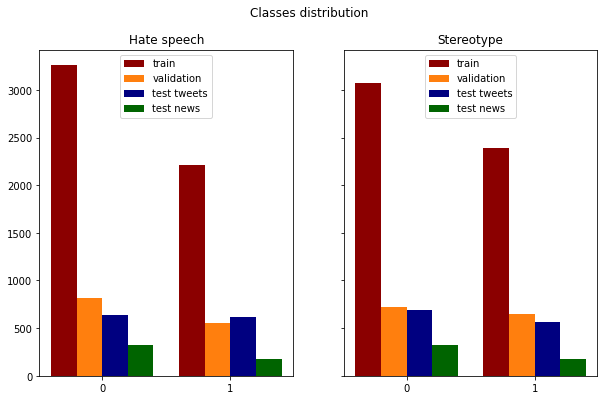

In [ ]:
column = 'hate_speech'
counts_train = np.asarray(df_train[column].tolist(), dtype=object)
counts_val =  np.asarray(df_val[column].tolist(), dtype=object)
counts_test_tweets =  np.asarray(df_test_tweets[column].tolist(), dtype=object)
counts_test_news =  np.asarray(df_test_news[column].tolist(), dtype=object)

fig, plots = plt.subplots(1,2, sharey=True, figsize=(10, 6))
fig.suptitle('Classes distribution')
plots[0].hist([counts_train, counts_val, counts_test_tweets, counts_test_news],
         bins=np.arange(3),
         label=['train', 'validation', 'test tweets', 'test news'],
         color=["darkred", "tab:orange", "navy", "darkgreen"], align='left')
plots[0].legend(loc='upper center')
plots[0].set_title("Hate speech")
plots[0].set_xticks(range(0,2))

column = 'stereotype'
counts_train = np.asarray(df_train[column].tolist(), dtype=object)
counts_val =  np.asarray(df_val[column].tolist(), dtype=object)
counts_test_tweets =  np.asarray(df_test_tweets[column].tolist(), dtype=object)
counts_test_news =  np.asarray(df_test_news[column].tolist(), dtype=object)

plots[1].hist([counts_train, counts_val, counts_test_tweets, counts_test_news],
         bins=np.arange(3),
         label=['train', 'validation', 'test tweets', 'test news'],
         color=["darkred", "tab:orange", "navy", "darkgreen"], align='left')
plots[1].legend(loc='upper center')
plots[1].set_title("Stereotype")
plots[1].set_xticks(range(0,2))

plt.show()

From the above histrograms it can be notice that the two classes, for both tasks, are slightly unbalanced.

# Pre-processing

From the above inspection of the data, it can be seen that the tweets have several symbols and elements that do not contain any information, such as *@user* and *URL*. Therefore, these instances are removed through regular expressions.  
Since *#hashtags* may be more meaningful, they are processed in order to make them more understandable, by removing the
\# character and, as far as possible, splitting those
containing multiple words attached.  
Also punctuation and stopwords are removed, except for "*non*" words, the presence/absence of which can strongly influence the meaning of the sentence.

In [ ]:
def cleaning_text(sentences):

  sentences_clean = sentences.replace(r'@[A-Za-z0-9_]+', '', regex=True)
  sentences_clean = sentences_clean.replace(r'\sURL', '', regex=True)
  sentences_clean = sentences_clean.replace(r"[^\w\s]", '', regex=True)

  return sentences_clean

In [ ]:
def process_hashtag(input_text):
    return re.sub(
        r'#[A-Za-z0-9_]\S*',
        lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*', m.group().lstrip('#'))),
        input_text,
    )

In [ ]:
def apply_process_hashtag(sentences):
  return sentences.apply(lambda x: process_hashtag(x))

In [ ]:
def remove_stopwords(sentences):

  return sentences.apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopwords_ita)]))

Additionally to the basic pre-processing just described, other stages, namely spelling correction and lemmatization are eventually applied.

In [ ]:
def spell_checker(sentences):

  spell_sentences = [spell(sentence) for sentence in sentences]

  return spell_sentences

In [ ]:
def lemmatization(sentences):

  lem_sentences = []

  for sentence in sentences:

    flag = True
    while flag:
      try:
        parsing = parse(sentence, lemmata=True).split()[0]
        flag=False
      except(RuntimeError):
        pass

    words = [parsing[i][4] for i in range(0, len(parsing))]
    lem_sentences.append(" ".join(words))

  return lem_sentences

In [ ]:
def tokenize_function(sentences):

  tokenizer = TweetTokenizer(strip_handles = True, reduce_len=True, preserve_case=False)

  tokenized_sentences = [tokenizer.tokenize(str(sentence)) for sentence in sentences]

  return tokenized_sentences

In [ ]:
def preprocessing_function(df, spell_check, lemma, labels):

  df_copy = df.copy()

  df_copy['clean_text'] = cleaning_text(df_copy['text'])
  df_copy['clean_text'] = apply_process_hashtag(df_copy['clean_text'])
  df_copy['clean_text'] = remove_stopwords(df_copy['clean_text'])

  if spell_check:
    df_copy['clean_text'] = spell_checker(df_copy['clean_text'])

  if lemma:
    df_copy['clean_text'] = lemmatization(df_copy['clean_text'])

  return df_copy['clean_text'], np.array(df_copy[labels].tolist())

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords_ita = stopwords.words('italian')
spell = Speller('it', fast=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Checking stopwords
stopwords_ita

['ad',
 'al',
 'allo',
 'ai',
 'agli',
 'all',
 'agl',
 'alla',
 'alle',
 'con',
 'col',
 'coi',
 'da',
 'dal',
 'dallo',
 'dai',
 'dagli',
 'dall',
 'dagl',
 'dalla',
 'dalle',
 'di',
 'del',
 'dello',
 'dei',
 'degli',
 'dell',
 'degl',
 'della',
 'delle',
 'in',
 'nel',
 'nello',
 'nei',
 'negli',
 'nell',
 'negl',
 'nella',
 'nelle',
 'su',
 'sul',
 'sullo',
 'sui',
 'sugli',
 'sull',
 'sugl',
 'sulla',
 'sulle',
 'per',
 'tra',
 'contro',
 'io',
 'tu',
 'lui',
 'lei',
 'noi',
 'voi',
 'loro',
 'mio',
 'mia',
 'miei',
 'mie',
 'tuo',
 'tua',
 'tuoi',
 'tue',
 'suo',
 'sua',
 'suoi',
 'sue',
 'nostro',
 'nostra',
 'nostri',
 'nostre',
 'vostro',
 'vostra',
 'vostri',
 'vostre',
 'mi',
 'ti',
 'ci',
 'vi',
 'lo',
 'la',
 'li',
 'le',
 'gli',
 'ne',
 'il',
 'un',
 'uno',
 'una',
 'ma',
 'ed',
 'se',
 'perché',
 'anche',
 'come',
 'dov',
 'dove',
 'che',
 'chi',
 'cui',
 'non',
 'più',
 'quale',
 'quanto',
 'quanti',
 'quanta',
 'quante',
 'quello',
 'quelli',
 'quella',
 'quelle',
 'q

In [ ]:
# Removing "non" from stopwords, since can have useful meaning for the task
print("The original number of stopwords is", len(stopwords_ita))
stopwords_ita.remove('non')
print("The number of stopwords after removing 'non' is", len(stopwords_ita))

The original number of stopwords is 279
The number of stopwords after removing 'non' is 278


# ML models

## TF-IDF words representation

A set of dictionaries is initialized to store the results of the ML models in order to compare them.





In [ ]:
set_reproducibility(42)

ml_scores_hs_dict = dict()
ml_models_hs_dict = dict()
ml_pred_tweets_hs_dict = dict()
ml_pred_news_hs_dict = dict()

ml_scores_st_dict = dict()
ml_models_st_dict = dict()
ml_pred_tweets_st_dict = dict()
ml_pred_news_st_dict = dict()

The `tf_idf_vectorization()` function computes the TF-IDF representation for each word. This is done in order to have suitable input features for the two ML models that will be used.

In [ ]:
def tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news):
  vectorizer =  TfidfVectorizer()

  X_train = vectorizer.fit_transform(sentences_train)
  X_val = vectorizer.transform(sentences_val)
  X_test_tweets = vectorizer.transform(sentences_test_tweets)
  X_test_news = vectorizer.transform(sentences_test_news)


  return X_train, X_val, X_test_tweets, X_test_news

## Support Vector Classifier

The first ML model used to classify both hate speech and stereotype language is the Support Vector Classifier.

Through the `svc_classifier()` function transformed data are used to train the SVC model and to make predictions on test tweets and news.

In [ ]:
def svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news):

  svc_classifier = LinearSVC(random_state = 42)

  svc_classifier.fit(X_train, labels_train)

  Y_pred_train = svc_classifier.predict(X_train)
  Y_pred_val = svc_classifier.predict(X_val)
  Y_pred_test_tweets = svc_classifier.predict(X_test_tweets)
  Y_pred_test_news = svc_classifier.predict(X_test_news)

  return Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_classifier

### Task A

Hate Speech Detection: binary classification task aimed at determining whether the message contains Hate Speech or not.

#### Basic pre-processing


In this section the SVC model is trained and evaluated on data that are only slightly pre-processed, i.e. without applying spelling correction or lemmatization.

In [ ]:
spell_check = False
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and the two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['svc'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['svc'] = svc
ml_pred_tweets_hs_dict['svc'] = Y_pred_test_tweets
ml_pred_news_hs_dict['svc'] = Y_pred_test_news


print('\n--------- Classification report Train set -----------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


--------- Classification report Train set -----------

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3259
           1       1.00      0.99      0.99      2208

    accuracy                           1.00      5467
   macro avg       1.00      0.99      0.99      5467
weighted avg       1.00      1.00      1.00      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       812
           1       0.71      0.71      0.71       555

    accuracy                           0.76      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       641
           1       0.71      0.73      0.72       622

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7556771506343223
Macro F1-score on the tweets test set: 0.717338958665718
Macro F1-score on the news test set: 0.6631407441997391


#### Spell-checking


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.

In [ ]:
spell_check = True
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_spell = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['svc_spell'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['svc_spell'] = svc_spell
ml_pred_tweets_hs_dict['svc_spell'] = Y_pred_test_tweets
ml_pred_news_hs_dict['svc_spell'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3259
           1       1.00      0.99      0.99      2208

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       812
           1       0.71      0.70      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       641
           1       0.71      0.73      0.72       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7516678749697925
Macro F1-score on the tweets test set: 0.7181270154920183
Macro F1-score on the news test set: 0.664686118479222


#### Lemmatization


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.


In [ ]:
spell_check = False
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_lemma = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['svc_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['svc_lemma'] = svc_lemma
ml_pred_tweets_hs_dict['svc_lemma'] = Y_pred_test_tweets
ml_pred_news_hs_dict['svc_lemma'] = Y_pred_test_news

print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3259
           1       0.99      0.99      0.99      2208

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       812
           1       0.70      0.71      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       641
           1       0.70      0.73      0.71       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7493459119148453
Macro F1-score on the tweets test set: 0.7133792221469947
Macro F1-score on the news test set: 0.6845440244637526


#### Spell-checking & lemmatization


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also the combination of spelling correction and lemmatization.

In [ ]:
spell_check = True
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_spell_lemma = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['svc_spell_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['svc_spell_lemma'] = svc_spell_lemma
ml_pred_tweets_hs_dict['svc_spell_lemma'] = Y_pred_test_tweets
ml_pred_news_hs_dict['svc_spell_lemma'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3259
           1       0.99      0.99      0.99      2208

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       812
           1       0.70      0.71      0.71       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       641
           1       0.70      0.72      0.71       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7516868916446251
Macro F1-score on the tweets test set: 0.7141718881745776
Macro F1-score on the news test set: 0.6854578934568214


### Task B

Stereotype Detection: binary classification task aimed at determining whether the message contains Stereotype or not.

#### Basic pre-processing


In this section the SVC model is trained and evaluated on data that are only slightly pre-processed, i.e. without applying spelling correction or lemmatization.

In [ ]:
spell_check = False
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['svc'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['svc'] = svc
ml_pred_tweets_st_dict['svc'] = Y_pred_test_tweets
ml_pred_news_st_dict['svc'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3074
           1       0.99      0.99      0.99      2393

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       722
           1       0.69      0.62      0.66       645

    accuracy                           0.69      1367
   macro avg       0.69      0.69      0.69      1367
weighted avg       0.69      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.65      0.70       694
           1       0.63      0.73      0.68       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6872833054547401
Macro F1-score on the tweets test set: 0.6878312255344776
Macro F1-score on the news test set: 0.6788977036275077


#### Spell-checking


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.

In [ ]:
spell_check = True
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_spell = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['svc_spell'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['svc_spell'] = svc_spell
ml_pred_tweets_st_dict['svc_spell'] = Y_pred_test_tweets
ml_pred_news_st_dict['svc_spell'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3074
           1       0.99      0.99      0.99      2393

    accuracy                           0.99      5467
   macro avg       0.99      0.99      0.99      5467
weighted avg       0.99      0.99      0.99      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       722
           1       0.70      0.62      0.66       645

    accuracy                           0.69      1367
   macro avg       0.69      0.69      0.69      1367
weighted avg       0.69      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.65      0.69       694
           1       0.63      0.73      0.68       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6899527058152306
Macro F1-score on the tweets test set: 0.6862466124661246
Macro F1-score on the news test set: 0.674798821262609


#### Lemmatization


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.

In [ ]:
spell_check = False
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_lemma = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['svc_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['svc_lemma'] = svc_lemma
ml_pred_tweets_st_dict['svc_lemma'] = Y_pred_test_tweets
ml_pred_news_st_dict['svc_lemma'] = Y_pred_test_news

print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3074
           1       0.98      0.98      0.98      2393

    accuracy                           0.98      5467
   macro avg       0.98      0.98      0.98      5467
weighted avg       0.98      0.98      0.98      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       722
           1       0.68      0.63      0.65       645

    accuracy                           0.69      1367
   macro avg       0.69      0.68      0.68      1367
weighted avg       0.69      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.76      0.66      0.71       694
           1       0.64      0.74      0.69       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6846972205491921
Macro F1-score on the tweets test set: 0.6980639696308961
Macro F1-score on the news test set: 0.6689373551618449


#### Spell-checking & lemmatization


In this section the SVC model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also the combination of spelling correction and lemmatization.

In [ ]:
spell_check = True
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, svc_spell_lemma = svc_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['svc_spell_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['svc_spell_lemma'] = svc_spell_lemma
ml_pred_tweets_st_dict['svc_spell_lemma'] = Y_pred_test_tweets
ml_pred_news_st_dict['svc_spell_lemma'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3074
           1       0.98      0.98      0.98      2393

    accuracy                           0.98      5467
   macro avg       0.98      0.98      0.98      5467
weighted avg       0.98      0.98      0.98      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.76      0.72       722
           1       0.70      0.62      0.66       645

    accuracy                           0.69      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.70      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       694
           1       0.63      0.75      0.69       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6915294923626304
Macro F1-score on the tweets test set: 0.6927099793820639
Macro F1-score on the news test set: 0.6764954175508966


## Logistic Regressor

The second ML model used to classify both hate speech and stereotype language is the Logistic Regressor.

Through the `lr_classifier()` function the transformed data are used to train and evaluate the LR model.


In [ ]:
def lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news):

  lr_classifier =  LogisticRegression(max_iter=1000, random_state = 42)

  lr_classifier.fit(X_train, labels_train)

  Y_pred_train = lr_classifier.predict(X_train)
  Y_pred_val = lr_classifier.predict(X_val)
  Y_pred_test_tweets = lr_classifier.predict(X_test_tweets)
  Y_pred_test_news = lr_classifier.predict(X_test_news)

  return Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_classifier

### Task A

Hate Speech Detection: binary classification task aimed at determining whether the message contains Hate Speech or not.

#### Basic pre-processing

In this section the LR model is trained and evaluated on data that are only slightly pre-processed, i.e. without applying spelling correction or lemmatization.

In [ ]:
spell_check = False
lemma= False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['lr'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['lr'] = lr
ml_pred_tweets_hs_dict['lr'] = Y_pred_test_tweets
ml_pred_news_hs_dict['lr'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3259
           1       0.92      0.79      0.85      2208

    accuracy                           0.89      5467
   macro avg       0.90      0.87      0.88      5467
weighted avg       0.89      0.89      0.89      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       812
           1       0.74      0.64      0.69       555

    accuracy                           0.76      1367
   macro avg       0.76      0.74      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       641
           1       0.73      0.69      0.71       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.746176974115683
Macro F1-score on the tweets test set: 0.7199948751862926
Macro F1-score on the news test set: 0.6532387129380054


#### Spell-checking


In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.

In [ ]:
spell_check = True
lemma= False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_spell = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['lr_spell'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['lr_spell'] = lr_spell
ml_pred_tweets_hs_dict['lr_spell'] = Y_pred_test_tweets
ml_pred_news_hs_dict['lr_spell'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3259
           1       0.92      0.79      0.85      2208

    accuracy                           0.89      5467
   macro avg       0.89      0.87      0.88      5467
weighted avg       0.89      0.89      0.89      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       812
           1       0.73      0.63      0.68       555

    accuracy                           0.76      1367
   macro avg       0.75      0.74      0.74      1367
weighted avg       0.76      0.76      0.75      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       641
           1       0.73      0.68      0.70       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7424913196667526
Macro F1-score on the tweets test set: 0.7182442304369001
Macro F1-score on the news test set: 0.6705448722947436


#### Lemmatization

In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.

In [ ]:
spell_check = False
lemma= True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_lemma = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['lr_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['lr_lemma'] = lr_lemma
ml_pred_tweets_hs_dict['lr_lemma'] = Y_pred_test_tweets
ml_pred_news_hs_dict['lr_lemma'] = Y_pred_test_news



print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3259
           1       0.90      0.78      0.83      2208

    accuracy                           0.88      5467
   macro avg       0.88      0.86      0.87      5467
weighted avg       0.88      0.88      0.87      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       812
           1       0.73      0.66      0.69       555

    accuracy                           0.76      1367
   macro avg       0.76      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       641
           1       0.74      0.68      0.71       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7505549143463084
Macro F1-score on the tweets test set: 0.7237338334975965
Macro F1-score on the news test set: 0.673944158645868


#### Spell-checking & lemmatization


In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction and lemmatization.

In [ ]:
spell_check = True
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'hate_speech')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_spell_lemma = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_hs_dict['lr_spell_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_hs_dict['lr_spell_lemma'] = lr_spell_lemma
ml_pred_tweets_hs_dict['lr_spell_lemma'] = Y_pred_test_tweets
ml_pred_news_hs_dict['lr_spell_lemma'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3259
           1       0.89      0.78      0.83      2208

    accuracy                           0.87      5467
   macro avg       0.88      0.86      0.87      5467
weighted avg       0.88      0.87      0.87      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       812
           1       0.74      0.66      0.70       555

    accuracy                           0.77      1367
   macro avg       0.76      0.75      0.75      1367
weighted avg       0.77      0.77      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       641
           1       0.74      0.69      0.71       622

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7539763929260276
Macro F1-score on the tweets test set: 0.7238213249820289
Macro F1-score on the news test set: 0.673944158645868


### Task B

Stereotype Detection: binary classification task aimed at determining whether the message contains Stereotype or not.

#### Basic pre-processing

In this section the LR model is trained and evaluated on data that are only slightly pre-processed, i.e. without applying spelling correction or lemmatization.

In [ ]:
spell_check = False
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['lr'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['lr'] = lr
ml_pred_tweets_st_dict['lr'] = Y_pred_test_tweets
ml_pred_news_st_dict['lr'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3074
           1       0.92      0.81      0.86      2393

    accuracy                           0.88      5467
   macro avg       0.89      0.88      0.88      5467
weighted avg       0.89      0.88      0.88      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       722
           1       0.74      0.56      0.64       645

    accuracy                           0.70      1367
   macro avg       0.71      0.69      0.69      1367
weighted avg       0.70      0.70      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       694
           1       0.67      0.69      0.68       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6882447689894058
Macro F1-score on the tweets test set: 0.7047663452207666
Macro F1-score on the news test set: 0.6804182869907827


#### Spell-checking


In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.

In [ ]:
spell_check = True
lemma = False

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_spell = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['lr_spell'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['lr_spell'] = lr_spell
ml_pred_tweets_st_dict['lr_spell'] = Y_pred_test_tweets
ml_pred_news_st_dict['lr_spell'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3074
           1       0.91      0.80      0.86      2393

    accuracy                           0.88      5467
   macro avg       0.89      0.87      0.88      5467
weighted avg       0.88      0.88      0.88      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       722
           1       0.73      0.57      0.64       645

    accuracy                           0.70      1367
   macro avg       0.71      0.69      0.69      1367
weighted avg       0.70      0.70      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       694
           1       0.66      0.68      0.67       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.690370321502397
Macro F1-score on the tweets test set: 0.6983829148471616
Macro F1-score on the news test set: 0.6723264540337711


#### Lemmatization

In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.

In [ ]:
spell_check = False
lemma= True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_lemma = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['lr_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['lr_lemma'] = lr_lemma
ml_pred_tweets_st_dict['lr_lemma'] = Y_pred_test_tweets
ml_pred_news_st_dict['lr_lemma'] = Y_pred_test_news


print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3074
           1       0.90      0.79      0.84      2393

    accuracy                           0.87      5467
   macro avg       0.88      0.86      0.87      5467
weighted avg       0.87      0.87      0.87      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       722
           1       0.73      0.58      0.65       645

    accuracy                           0.70      1367
   macro avg       0.71      0.70      0.69      1367
weighted avg       0.71      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.72      0.74       694
           1       0.68      0.71      0.69       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6949304864441026
Macro F1-score on the tweets test set: 0.7164589849661991
Macro F1-score on the news test set: 0.6656442174541015


#### Spell-checking & lemmatization


In this section the LR model is trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction and lemmatization.

In [ ]:
spell_check = True
lemma = True

sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma,'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma,'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma,'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma,'stereotype')

In [ ]:
X_train, X_val, X_test_tweets, X_test_news = tf_idf_vectorization(sentences_train, sentences_val, sentences_test_tweets, sentences_test_news)
Y_pred_train, Y_pred_val, Y_pred_test_tweets, Y_pred_test_news, lr_spell_lemma = lr_classifier(X_train, labels_train, X_val, X_test_tweets, X_test_news)

A classification report for the training, validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
report_train = classification_report(labels_train, Y_pred_train)
report_val = classification_report(labels_val, Y_pred_val)
report_test_tweets = classification_report(labels_test_tweets, Y_pred_test_tweets)
report_test_news = classification_report(labels_test_news, Y_pred_test_news)

ml_scores_st_dict['lr_spell_lemma'] = classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)
ml_models_st_dict['lr_spell_lemma'] = lr_spell_lemma
ml_pred_tweets_st_dict['lr_spell_lemma'] = Y_pred_test_tweets
ml_pred_news_st_dict['lr_spell_lemma'] = Y_pred_test_news



print('\n-------- Classification report Train set --------\n')
print(report_train)
print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Train set --------

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3074
           1       0.89      0.79      0.84      2393

    accuracy                           0.87      5467
   macro avg       0.87      0.86      0.86      5467
weighted avg       0.87      0.87      0.86      5467


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       722
           1       0.74      0.58      0.65       645

    accuracy                           0.70      1367
   macro avg       0.71      0.70      0.70      1367
weighted avg       0.71      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       694
           1       0.67      0.71      0.69       569

    accuracy   

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, Y_pred_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, Y_pred_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, Y_pred_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6964295995328293
Macro F1-score on the tweets test set: 0.712647908716491
Macro F1-score on the news test set: 0.6659372501998402


# RNN models

## Embedding

Before feeding DL models, words are represented through a FastText embedding for Italian language, which associates to each word a vector of 300 floating numbers.  
For computational reasons, the FastText model used is a compressed version of the original one.

In [ ]:
# Download FastText embedding

ft_ita = compress_fasttext.models.CompressedFastTextKeyedVectors.load("https://zenodo.org/record/4905385/files/fasttext-it-mini?download=1")

In [ ]:
embedding_dim = ft_ita[ft_ita.index_to_key[0]].shape[0]
print("The FastText embedding model contains",len(ft_ita.index_to_key),"embeddings of size", embedding_dim)

The FastText embedding model contains 20000 embeddings of size 300


The `find_unique_words()` function returns a list of unique words starting from a set of messages (tweets or news).


In [ ]:
def find_unique_words(token_sentences):

  flattened = list(itertools.chain(*token_sentences))
  list_of_words = sorted(list(set(flattened)))

  return list_of_words

The `load_vocabulary()` function is used to build a vocabulary that contains all the pairs {word : embedding} using the FastText pre-trained embeddings.



In [ ]:
def load_vocabulary(embeddings):

  vocabulary = {}

  for word in embeddings.key_to_index:
    vocabulary[word] = embeddings[word]

  return vocabulary

Starting from the FastText vocabulary, a costumed one is created by adding to FastText an embedding for the Out Of Vocabulary (OOV) terms.  
The embeddings for OOV words is obtained by summing up vectors for its component char-ngrams if at least one of the char-ngrams was
present in the train data, creating an embedding vector of 0s otherwise.

In [ ]:
def add_OOV_embedding(embeddings, list_of_words, vocabulary):

  """
  For all the words in `list_of_words` not contained into `vocabulary` (OOV terms), compute a random embedding and add it to `vocabulary`.
  """
  vocabulary_copy = vocabulary.copy()

  for word in list_of_words:
    if word not in vocabulary_copy.keys():
      vocabulary_copy[word] = embeddings.word_vec(word)

  return vocabulary_copy

The `create_vocabulary` function builds the final vocabulary considering all the words contained in the train, validation and two test sets.

In [ ]:
def create_vocabulary(ft_embeddings, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news):

  print("Loading the vocabulary from the FastText embeddings...")
  vocabulary = load_vocabulary(ft_embeddings)
  print("Done! The size of the vocabulary is", len(vocabulary),'\n')

  print("Adding OOV embeddings to the vocabulary...")
  vocabulary_1 = vocabulary.copy()
  vocabulary_2 = add_OOV_embedding(ft_ita, list_of_words_train, vocabulary_1)
  print("Vocabulary size after train OOV words:", len(vocabulary_2))
  vocabulary_3 = add_OOV_embedding(ft_ita, list_of_words_val, vocabulary_2)
  print("Vocabulary size after val OOV words:  ", len(vocabulary_3))
  vocabulary_4 = add_OOV_embedding(ft_ita, list_of_words_test_tweets, vocabulary_3)
  print("Vocabulary size after test tweets OOV words: ", len(vocabulary_4))
  vocabulary_5 = add_OOV_embedding(ft_ita, list_of_words_test_news, vocabulary_4)
  print("Vocabulary size after test news OOV words: ", len(vocabulary_5))
  vocab_size = len(vocabulary_5)
  print("The final total size of the vocabulary is", vocab_size,'\n')

  return vocabulary_5, vocab_size

The `create_embedding_matrix()` function returns a matrix of size ((vocabulary size + 1)  X embedding size).


In [ ]:
def create_embedding_matrix(vocabulary, vocab_size, embedding_dim):

  # Creating word:index dictionary
  indexes = np.arange(1, vocab_size+1) # +1 for padding and starting from 1 because 0 index is reserved for padding
  word2id_dict = dict(zip(vocabulary.keys(), indexes))

  # Creating the embedding matrix
  embedding_matrix = np.zeros((vocab_size+1, embedding_dim))

  for word, i in word2id_dict.items():
    embedding_matrix[i] = vocabulary.get(word)

  print("The shape of the created embedding matrix is:", embedding_matrix.shape)

  return word2id_dict, embedding_matrix

The `sentences_2_indexes()` function converts each word in the message (tweet or news) in an index. This number will be used as row index in the embedding matrix.



In [ ]:
def sentences_2_indexes(sentences, word2id_dict):
    """
    Convert each word in `sentences` into numerical format, according to `word2id_dict`.
    """
    matrix = [np.array([word2id_dict[word] for word in sentence]) for sentence in sentences]
    return matrix

## Models definition

In order to obtain fully reproducibility for experiments, it is needed to always reset Tensorflow and Keras backends and to set again the random seed before creating a new Keras model. The `reset_session()` function is in charge of doing that.


In [ ]:
def reset_session(seed):

  K.clear_session()
  np.random.seed(seed)
  v1.set_random_seed(seed)
  sess = v1.Session(graph=v1.get_default_graph())
  K.set_session(sess)

The first DL model defined is composed by
* the **Input layer**, which takes as input sentences as a sequence of indexes
* an **Embedding layer**, which is a simple lookup table that stores embeddings of each vocabulary word. Given the input as a list of indexes, it retrieves the correspondent word embeddings. In this case, it has been initialized with the `embedding_matrix` previously computed and it is set to be trainable. Through the option `mask_zero = True` it allows the following layers of the network to ignore padding.
* a **Dropout layer** of size $0.5$
* a **Bidirectional LSTM layer** of size $64$
* a **Global Max Pooling 1D layer**
* a **Dense layer** of size $64$ with a ReLU activation function
* a **Dropout layer** of size $0.5$
* a **Dense layer** of size $1$ with a Sigmoid activation function

When compiling the model, the following setup is used:

* Adam optimizer with learning rate of 0.0001
* Binary Cross Entropy Loss
* Accuracy as metric

In [ ]:
def create_M1(seed):

  reset_session(seed)

  model = Sequential([
      InputLayer(input_shape=(max_seq_length,)),
      Embedding(vocab_size+1, 300,
                      weights = [embedding_matrix],
                      input_length = (max_seq_length, 300),
                      trainable = True,
                      mask_zero = True),
      Dropout(0.5),
      Bidirectional(LSTM(64, return_sequences=True)),
      GlobalMaxPool1D(),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
      ])

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.0001),
                metrics=['accuracy'])

  return model

The second DL model defined is composed by
* the **Input layer**, which takes as input sentences as a sequence of indexes
* an **Embedding layer**, which is a simple lookup table that stores embeddings of each vocabulary word. Given the input as a list of indexes, it retrieves the correspondent word embeddings. In this case, it has been initialized with the `embedding_matrix` previously computed and it is set to be trainable. Through the option `mask_zero = True` it allows the following layers of the network to ignore padding.
* a **Dropout layer** of size $0.5$
* a **Bidirectional LSTM layer** of size $16$
* a **Bidirectional LSTM layer** of size $16$
* a **Global Max Pooling 1D layer**
* a **Dense layer** of size $1$ with a Sigmoid activation function

When compiling the model, the following setup is used:

* Adam optimizer with learning rate of 0.0001
* Binary Cross Entropy Loss
* Accuracy as metric

In [ ]:
def create_M2(seed):

  reset_session(seed)

  model = Sequential([
      InputLayer(input_shape=(max_seq_length,)),
      Embedding(vocab_size+1, 300,
                      weights = [embedding_matrix],
                      input_length = (max_seq_length, 300),
                      trainable = True,
                      mask_zero = True),
      Dropout(0.5),
      Bidirectional(LSTM(16, return_sequences=True)),
      Bidirectional(LSTM(16, return_sequences=True)),
      GlobalMaxPool1D(),
      Dense(1, activation='sigmoid')
      ])

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.0001),
                metrics=['accuracy'])

  return model

## Training & evaluation

A set of dictionaries is initialized to store the results of the DL models in order to compare them.





In [ ]:
seed = 42
set_reproducibility(seed)

# {model : scores}
rnn_scores_hs_dict = dict()

# {model name : model}
rnn_models_hs_dict = dict()

# {model_name : predictions_tweets}
rnn_pred_tweets_hs_dict = dict()

# {model_name : predictions_news}
rnn_pred_news_hs_dict = dict()

# {model : scores}
rnn_scores_st_dict = dict()

# {model name : model}
rnn_models_st_dict = dict()

# {model_name : predictions_tweets}
rnn_pred_tweets_st_dict = dict()

# {model_name : predictions_news}
rnn_pred_news_st_dict = dict()

### Task A

Hate Speech Detection: binary classification task aimed at determining whether the message contains Hate Speech or not.

#### Basic pre-processing

In this section the two RNN models are trained and evaluated on data that are only slightly pre-processed, i.e. without applying spelling correction or lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.

In [ ]:
spell_check = False
lemma = False

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'hate_speech')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 31674
Vocabulary size after val OOV words:   33842
Vocabulary size after test tweets OOV words:  36408
Vocabulary size after test news OOV words:  36729
The final total size of the vocabulary is 36729 

The shape of the created embedding matrix is: (36730, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivoli roma rugantina proviene dallex campo rom stacchini tiv
Numerical format: [29246, 29193, 26782, 24712, 25105, 30810, 11507, 29246, 7327, 22802, 469, 15234, 30329, 30809]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[29246, 29193, 26782, 24712, 25105, 30810, 11507, 29246, 7327, 22802, 469, 15234, 30329, 30809, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1 = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1.save('drive/MyDrive/Colab Notebooks/hate_weights/M1')

In [ ]:
#M1 = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M1')

In [ ]:
predictions_test_tweets = M1.predict(pad_sent_test_tweets)
predictions_val = M1.predict(pad_sent_val)
predictions_test_news = M1.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M1'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M1'] = M1
rnn_pred_tweets_hs_dict['M1'] = classes_test_tweets
rnn_pred_news_hs_dict['M1'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       812
           1       0.72      0.71      0.71       555

    accuracy                           0.77      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.77      0.77      0.77      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       641
           1       0.71      0.76      0.73       622

    accuracy                           0.73      1263
   macro avg       0.73      0.73      0.73      1263
weighted avg       0.73      0.73      0.73      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       319
           1       0.83      0.34      0.49       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7591213528902002
Macro F1-score on the tweets test set: 0.7259417112353124
Macro F1-score on the news test set: 0.654981131079619


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2 = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2.save('drive/MyDrive/Colab Notebooks/hate_weights/M2')

In [ ]:
#M2 = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M2')

In [ ]:
predictions_test_tweets = M2.predict(pad_sent_test_tweets)
predictions_val = M2.predict(pad_sent_val)
predictions_test_news = M2.predict(pad_sent_test_news)

16/16 [==============================] - 0s 10ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M2'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M2'] = M2
rnn_pred_tweets_hs_dict['M2'] = classes_test_tweets
rnn_pred_news_hs_dict['M2'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       812
           1       0.72      0.71      0.71       555

    accuracy                           0.77      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.77      0.77      0.77      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       641
           1       0.73      0.72      0.72       622

    accuracy                           0.73      1263
   macro avg       0.73      0.73      0.73      1263
weighted avg       0.73      0.73      0.73      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       319
           1       0.81      0.38      0.52       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7585728503450022
Macro F1-score on the tweets test set: 0.7283419609515358
Macro F1-score on the news test set: 0.6703822970852944


#### Spell-checking

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.


In [ ]:
spell_check = True
lemma = False

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'hate_speech')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 30917
Vocabulary size after val OOV words:   32902
Vocabulary size after test tweets OOV words:  35208
Vocabulary size after test news OOV words:  35514
The final total size of the vocabulary is 35514 

The shape of the created embedding matrix is: (35515, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivoli roma rugantina proviene dalle campo rom tacchini tiv
Numerical format: [28630, 28583, 26314, 24480, 24865, 30106, 11507, 28630, 7327, 216, 469, 15234, 29936, 30105]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[28630, 28583, 26314, 24480, 24865, 30106, 11507, 28630, 7327, 216, 469, 15234, 29936, 30105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_spell = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_spell.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell')

"M1_spell = create_M1(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_spell.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell')"

In [ ]:
#M1_spell = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell')

In [ ]:
predictions_test_tweets = M1_spell.predict(pad_sent_test_tweets)
predictions_val = M1_spell.predict(pad_sent_val)
predictions_test_news = M1_spell.predict(pad_sent_test_news)

16/16 [==============================] - 0s 8ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M1_spell'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M1_spell'] = M1_spell
rnn_pred_tweets_hs_dict['M1_spell'] = classes_test_tweets
rnn_pred_news_hs_dict['M1_spell'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       812
           1       0.71      0.71      0.71       555

    accuracy                           0.76      1367
   macro avg       0.76      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.76      0.68      0.71       641
           1       0.70      0.77      0.73       622

    accuracy                           0.73      1263
   macro avg       0.73      0.73      0.72      1263
weighted avg       0.73      0.73      0.72      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       319
           1       0.83      0.36      0.50       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7549886939030311
Macro F1-score on the tweets test set: 0.7248923921551889
Macro F1-score on the news test set: 0.6654514980096375


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_spell = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_spell.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell')

"M2_spell = create_M2(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_spell.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell')"

In [ ]:
#M2_spell = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell')

In [ ]:
predictions_test_tweets = M2_spell.predict(pad_sent_test_tweets)
predictions_val = M2_spell.predict(pad_sent_val)
predictions_test_news = M2_spell.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M2_spell'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M2_spell'] = M2_spell
rnn_pred_tweets_hs_dict['M2_spell'] = classes_test_tweets
rnn_pred_news_hs_dict['M2_spell'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       812
           1       0.71      0.70      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       641
           1       0.73      0.73      0.73       622

    accuracy                           0.73      1263
   macro avg       0.73      0.73      0.73      1263
weighted avg       0.73      0.73      0.73      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       319
           1       0.81      0.40      0.54       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7516678749697925
Macro F1-score on the tweets test set: 0.7307617069941014
Macro F1-score on the news test set: 0.6819241105348774


#### Lemmatization

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.

In [ ]:
spell_check = False
lemma = True

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'hate_speech')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 30506
Vocabulary size after val OOV words:   32385
Vocabulary size after test tweets OOV words:  34507
Vocabulary size after test news OOV words:  34785
The final total size of the vocabulary is 34785 

The shape of the created embedding matrix is: (34786, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivolo roma rugantina provenire dallex campo rom stacchino tiv
Numerical format: [28404, 28367, 26215, 24302, 24654, 29744, 11507, 28404, 27685, 22530, 469, 15234, 29314, 29743]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[28404, 28367, 26215, 24302, 24654, 29744, 11507, 28404, 27685, 22530, 469, 15234, 29314, 29743, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_lemma = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_lemma')

"M1_lemma = create_M1(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_lemma')"

In [ ]:
#M1_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M1_lemma')

In [ ]:
predictions_test_tweets = M1_lemma.predict(pad_sent_test_tweets)
predictions_val = M1_lemma.predict(pad_sent_val)
predictions_test_news = M1_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M1_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M1_lemma'] = M1_lemma
rnn_pred_tweets_hs_dict['M1_lemma'] = classes_test_tweets
rnn_pred_news_hs_dict['M1_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       812
           1       0.71      0.67      0.69       555

    accuracy                           0.75      1367
   macro avg       0.74      0.74      0.74      1367
weighted avg       0.75      0.75      0.75      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.69      0.71       641
           1       0.70      0.76      0.73       622

    accuracy                           0.72      1263
   macro avg       0.72      0.72      0.72      1263
weighted avg       0.72      0.72      0.72      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       319
           1       0.84      0.37      0.52       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7425173195317369
Macro F1-score on the tweets test set: 0.7219117457947677
Macro F1-score on the news test set: 0.6723264540337711


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_lemma = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_lemma')

"M2_lemma = create_M2(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_lemma')"

In [ ]:
#M2_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M2_lemma')

In [ ]:
predictions_test_tweets = M2_lemma.predict(pad_sent_test_tweets)
predictions_val = M2_lemma.predict(pad_sent_val)
predictions_test_news = M2_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 9ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M2_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M2_lemma'] = M2_lemma
rnn_pred_tweets_hs_dict['M2_lemma'] = classes_test_tweets
rnn_pred_news_hs_dict['M2_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       812
           1       0.71      0.70      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       641
           1       0.72      0.71      0.72       622

    accuracy                           0.72      1263
   macro avg       0.72      0.72      0.72      1263
weighted avg       0.72      0.72      0.72      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       319
           1       0.83      0.43      0.56       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7532886821207989
Macro F1-score on the tweets test set: 0.7243202151627519
Macro F1-score on the news test set: 0.6999823165340406


#### Spell-checking & lemmatization

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction and lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.


In [ ]:
spell_check = True
lemma = True

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'hate_speech')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'hate_speech')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'hate_speech')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'hate_speech')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 29781
Vocabulary size after val OOV words:   31496
Vocabulary size after test tweets OOV words:  33392
Vocabulary size after test news OOV words:  33659
The final total size of the vocabulary is 33659 

The shape of the created embedding matrix is: (33660, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivolo roma rugantina provenire dalle campo rom tacchino tiv
Numerical format: [27803, 27770, 25758, 24073, 24415, 29066, 11507, 27803, 27131, 216, 469, 15234, 28916, 29065]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[27803, 27770, 25758, 24073, 24415, 29066, 11507, 27803, 27131, 216, 469, 15234, 28916, 29065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_spell_lemma = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_spell_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell_lemma')

"M1_spell_lemma = create_M1(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_spell_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell_lemma')"

In [ ]:
#M1_spell_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M1_spell_lemma')

In [ ]:
predictions_test_tweets = M1_spell_lemma.predict(pad_sent_test_tweets)
predictions_val = M1_spell_lemma.predict(pad_sent_val)
predictions_test_news = M1_spell_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 8ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M1_spell_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M1_spell_lemma'] = M1_spell_lemma
rnn_pred_tweets_hs_dict['M1_spell_lemma'] = classes_test_tweets
rnn_pred_news_hs_dict['M1_spell_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       812
           1       0.69      0.70      0.70       555

    accuracy                           0.75      1367
   macro avg       0.74      0.74      0.74      1367
weighted avg       0.75      0.75      0.75      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       641
           1       0.69      0.77      0.73       622

    accuracy                           0.71      1263
   macro avg       0.72      0.72      0.71      1263
weighted avg       0.72      0.71      0.71      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       319
           1       0.81      0.40      0.54       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7439734468160559
Macro F1-score on the tweets test set: 0.7136095797009233
Macro F1-score on the news test set: 0.6819241105348774


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_spell_lemma = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_spell_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell_lemma')

"M2_spell_lemma = create_M2(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_spell_lemma.save('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell_lemma')"

In [ ]:
#M2_spell_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/hate_weights/M2_spell_lemma')

In [ ]:
predictions_test_tweets = M2_spell_lemma.predict(pad_sent_test_tweets)
predictions_val = M2_spell_lemma.predict(pad_sent_val)
predictions_test_news = M2_spell_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_hs_dict['M2_spell_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_hs_dict['M2_spell_lemma'] = M2_spell_lemma
rnn_pred_tweets_hs_dict['M2_spell_lemma'] = classes_test_tweets
rnn_pred_news_hs_dict['M2_spell_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       812
           1       0.71      0.69      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       641
           1       0.70      0.74      0.72       622

    accuracy                           0.72      1263
   macro avg       0.72      0.72      0.72      1263
weighted avg       0.72      0.72      0.72      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       319
           1       0.87      0.41      0.56       180

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7487199540119248
Macro F1-score on the tweets test set: 0.7188886583033067
Macro F1-score on the news test set: 0.6994362789260985


### Task B

Stereotype Detection: binary classification task aimed at determining whether the message contains Stereotype or not.

#### Basic pre-processing

In this section the two DL models are trained and evaluated on data that are only slightly pre-processed, i.e. without spelling correction and lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.


In [ ]:
spell_check = False
lemma = False

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'stereotype')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 31674
Vocabulary size after val OOV words:   33842
Vocabulary size after test tweets OOV words:  36408
Vocabulary size after test news OOV words:  36729
The final total size of the vocabulary is 36729 

The shape of the created embedding matrix is: (36730, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivoli roma rugantina proviene dallex campo rom stacchini tiv
Numerical format: [29246, 29193, 26782, 24712, 25105, 30810, 11507, 29246, 7327, 22802, 469, 15234, 30329, 30809]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[29246, 29193, 26782, 24712, 25105, 30810, 11507, 29246, 7327, 22802, 469, 15234, 30329, 30809, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1 = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1')

"M1 = create_M1(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1')"

In [ ]:
#M1 = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M1')

In [ ]:
predictions_test_tweets = M1.predict(pad_sent_test_tweets)
predictions_val = M1.predict(pad_sent_val)
predictions_test_news = M1.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M1'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M1'] = M1
rnn_pred_tweets_st_dict['M1'] = classes_test_tweets
rnn_pred_news_st_dict['M1'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       722
           1       0.73      0.59      0.65       645

    accuracy                           0.70      1367
   macro avg       0.71      0.70      0.69      1367
weighted avg       0.71      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.77      0.65      0.71       694
           1       0.64      0.76      0.70       569

    accuracy                           0.70      1263
   macro avg       0.71      0.71      0.70      1263
weighted avg       0.71      0.70      0.70      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.72      0.94      0.82       324
           1       0.74      0.34      0.46       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6949408408303287
Macro F1-score on the tweets test set: 0.7014137588301137
Macro F1-score on the news test set: 0.6391787401367007


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2 = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2')

"M2 = create_M2(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2')"

In [ ]:
#M2 = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M2')

In [ ]:
predictions_test_tweets = M2.predict(pad_sent_test_tweets)
predictions_val = M2.predict(pad_sent_val)
predictions_test_news = M2.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M2'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M2'] = M2
rnn_pred_tweets_st_dict['M2'] = classes_test_tweets
rnn_pred_news_st_dict['M2'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       722
           1       0.71      0.61      0.66       645

    accuracy                           0.70      1367
   macro avg       0.70      0.70      0.70      1367
weighted avg       0.70      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.76      0.66      0.70       694
           1       0.64      0.74      0.69       569

    accuracy                           0.70      1263
   macro avg       0.70      0.70      0.70      1263
weighted avg       0.70      0.70      0.70      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       324
           1       0.73      0.41      0.53       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6950759059532203
Macro F1-score on the tweets test set: 0.6957283317356193
Macro F1-score on the news test set: 0.6747707464948844


#### Spell-checking

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.

In [ ]:
spell_check = True
lemma = False

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'stereotype')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 30917
Vocabulary size after val OOV words:   32902
Vocabulary size after test tweets OOV words:  35208
Vocabulary size after test news OOV words:  35514
The final total size of the vocabulary is 35514 

The shape of the created embedding matrix is: (35515, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivoli roma rugantina proviene dalle campo rom tacchini tiv
Numerical format: [28630, 28583, 26314, 24480, 24865, 30106, 11507, 28630, 7327, 216, 469, 15234, 29936, 30105]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[28630, 28583, 26314, 24480, 24865, 30106, 11507, 28630, 7327, 216, 469, 15234, 29936, 30105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_spell = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_spell.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell')

"M1_spell = create_M1(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_spell.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell')"

In [ ]:
#M1_spell = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell')

In [ ]:
predictions_test_tweets = M1_spell.predict(pad_sent_test_tweets)
predictions_val = M1_spell.predict(pad_sent_val)
predictions_test_news = M1_spell.predict(pad_sent_test_news)

16/16 [==============================] - 0s 4ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M1_spell'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M1_spell'] = M1_spell
rnn_pred_tweets_st_dict['M1_spell'] = classes_test_tweets
rnn_pred_news_st_dict['M1_spell'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       722
           1       0.73      0.58      0.65       645

    accuracy                           0.70      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.70      0.70      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.77      0.65      0.70       694
           1       0.64      0.77      0.70       569

    accuracy                           0.70      1263
   macro avg       0.71      0.71      0.70      1263
weighted avg       0.71      0.70      0.70      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       324
           1       0.71      0.29      0.41       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6923553308331322
Macro F1-score on the tweets test set: 0.7014676737474553
Macro F1-score on the news test set: 0.6099397833927234


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_spell = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_spell.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell')

"M2_spell = create_M2(seed)\ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_spell.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_spell.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell')"

In [ ]:
#M2_spell = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell')

In [ ]:
predictions_test_tweets = M2_spell.predict(pad_sent_test_tweets)
predictions_val = M2_spell.predict(pad_sent_val)
predictions_test_news = M2_spell.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M2_spell'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M2_spell'] = M2_spell
rnn_pred_tweets_st_dict['M2_spell'] = classes_test_tweets
rnn_pred_news_st_dict['M2_spell'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       722
           1       0.72      0.59      0.65       645

    accuracy                           0.70      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.70      0.70      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       694
           1       0.65      0.72      0.68       569

    accuracy                           0.70      1263
   macro avg       0.70      0.70      0.70      1263
weighted avg       0.70      0.70      0.70      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       324
           1       0.72      0.39      0.51       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6914044116240363
Macro F1-score on the tweets test set: 0.696791101055807
Macro F1-score on the news test set: 0.6615672536091096


#### Lemmatization

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.


In [ ]:
spell_check = False
lemma = True

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'stereotype')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 30506
Vocabulary size after val OOV words:   32385
Vocabulary size after test tweets OOV words:  34507
Vocabulary size after test news OOV words:  34785
The final total size of the vocabulary is 34785 

The shape of the created embedding matrix is: (34786, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivolo roma rugantina provenire dallex campo rom stacchino tiv
Numerical format: [28404, 28367, 26215, 24302, 24654, 29744, 11507, 28404, 27685, 22530, 469, 15234, 29314, 29743]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[28404, 28367, 26215, 24302, 24654, 29744, 11507, 28404, 27685, 22530, 469, 15234, 29314, 29743, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_lemma = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_lemma')

"M1_lemma = create_M1(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_lemma')"

In [ ]:
#M1_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M1_lemma')

In [ ]:
predictions_test_tweets = M1_lemma.predict(pad_sent_test_tweets)
predictions_val = M1_lemma.predict(pad_sent_val)
predictions_test_news = M1_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M1_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M1_lemma'] = M1_lemma
rnn_pred_tweets_st_dict['M1_lemma'] = classes_test_tweets
rnn_pred_news_st_dict['M1_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       722
           1       0.71      0.64      0.67       645

    accuracy                           0.71      1367
   macro avg       0.71      0.70      0.70      1367
weighted avg       0.71      0.71      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       694
           1       0.62      0.80      0.70       569

    accuracy                           0.69      1263
   macro avg       0.71      0.70      0.69      1263
weighted avg       0.71      0.69      0.69      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       324
           1       0.73      0.41      0.52       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7026717309440331
Macro F1-score on the tweets test set: 0.6916621951104711
Macro F1-score on the news test set: 0.6714977313239345


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_lemma = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_lemma')

"M2_lemma = create_M2(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_lemma')"

In [ ]:
M2_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M2_lemma')

In [ ]:
predictions_test_tweets = M2_lemma.predict(pad_sent_test_tweets)
predictions_val = M2_lemma.predict(pad_sent_val)
predictions_test_news = M2_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 8ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M2_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M2_lemma'] = M2_lemma
rnn_pred_tweets_st_dict['M2_lemma'] = classes_test_tweets
rnn_pred_news_st_dict['M2_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       722
           1       0.72      0.57      0.64       645

    accuracy                           0.69      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.70      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       694
           1       0.67      0.72      0.69       569

    accuracy                           0.71      1263
   macro avg       0.71      0.71      0.71      1263
weighted avg       0.72      0.71      0.71      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.73      0.90      0.81       324
           1       0.67      0.39      0.49       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6854041187764657
Macro F1-score on the tweets test set: 0.7113121043653695
Macro F1-score on the news test set: 0.6494239030069453


#### Spell-checking & lemmatization

In this section the two DL models are trained and evaluated on data which underwent, in addition to the basic pre-processing, also spelling correction and lemmatization.
In addition, after the pre-processing phase, data are tokenized using the `tokenize_function`, which uses the `TweetTokenizer` from nltk package. After tokenization, a the list of unique words is built.


In [ ]:
spell_check = True
lemma = True

# Preprocessing sentences
sentences_train, labels_train = preprocessing_function(df_train, spell_check, lemma, 'stereotype')
sentences_val, labels_val = preprocessing_function(df_val, spell_check, lemma, 'stereotype')
sentences_test_tweets, labels_test_tweets = preprocessing_function(df_test_tweets, spell_check, lemma, 'stereotype')
sentences_test_news, labels_test_news = preprocessing_function(df_test_news, spell_check, lemma, 'stereotype')

# Tokenization
token_sentences_train = tokenize_function(sentences_train)
token_sentences_val = tokenize_function(sentences_val)
token_sentences_test_tweets = tokenize_function(sentences_test_tweets)
token_sentences_test_news = tokenize_function(sentences_test_news)

# Unique words
list_of_words_train = find_unique_words(token_sentences_train)
list_of_words_val = find_unique_words(token_sentences_val)
list_of_words_test_tweets = find_unique_words(token_sentences_test_tweets)
list_of_words_test_news = find_unique_words(token_sentences_test_news)

Using lists of unique words, the vocabulary is created and then used to build the embedding matrix that will be used as initialization for the embedding layer in the models.

In [ ]:
# Create the vocabulary
vocabulary, vocab_size = create_vocabulary(ft_ita, embedding_dim, list_of_words_train, list_of_words_val, list_of_words_test_tweets, list_of_words_test_news)

# Create embedding matrix
word2id_dict, embedding_matrix = create_embedding_matrix(vocabulary, vocab_size, embedding_dim)

Loading the vocabulary from the FastText embeddings...
Done! The size of the vocabulary is 20000 

Adding OOV embeddings to the vocabulary...
Vocabulary size after train OOV words: 29781
Vocabulary size after val OOV words:   31496
Vocabulary size after test tweets OOV words:  33392
Vocabulary size after test news OOV words:  33659
The final total size of the vocabulary is 33659 

The shape of the created embedding matrix is: (33660, 300)


Then each sample is converted in numerical format.

In [ ]:
# Sentences conversion into numerical format
ids_word_train = sentences_2_indexes(token_sentences_train, word2id_dict)
ids_word_val = sentences_2_indexes(token_sentences_val, word2id_dict)
ids_word_test_tweets = sentences_2_indexes(token_sentences_test_tweets, word2id_dict)
ids_word_test_news = sentences_2_indexes(token_sentences_test_news, word2id_dict)

print("Original sentence:", sentences_train[0])
print("Numerical format:", list(ids_word_train[0]))

Original sentence: rugantina rosetta minù hermes indio tivolo roma rugantina provenire dalle campo rom tacchino tiv
Numerical format: [27803, 27770, 25758, 24073, 24415, 29066, 11507, 27803, 27131, 216, 469, 15234, 28916, 29065]


The messages in the corpus are not of the same length. Before feeding the input in the models, it's needed to fix the length of the tweets and the news. Therefore, the next step after encoding the data is to define the maximum sequence length. It has been decided to compute `max_seq_length` as to handle the 99% of the training tweets.

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in token_sentences_train], 0.99))
print('The computed sentence maximum length is', max_seq_length)

The computed sentence maximum length is 29


Then, all the sentences shorter than `max_seq_length` have been padded with as many 0s as to reach the maximum length, while the longer ones have simply been truncated.

In [ ]:
pad_sent_train = pad_sequences(ids_word_train, maxlen=max_seq_length, padding='post')
pad_sent_val = pad_sequences(ids_word_val, maxlen=max_seq_length, padding='post')
pad_sent_test_tweets = pad_sequences(ids_word_test_tweets, maxlen=max_seq_length, padding='post')
pad_sent_test_news = pad_sequences(ids_word_test_news, maxlen=max_seq_length, padding='post')

print("Padded sentence:")
print(list(pad_sent_train[0]))

Padded sentence:
[27803, 27770, 25758, 24073, 24415, 29066, 11507, 27803, 27131, 216, 469, 15234, 28916, 29065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### Modello 1

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M1_spell_lemma = create_M1(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M1_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M1_spell_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell_lemma')

"M1_spell_lemma = create_M1(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M1_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM1_spell_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell_lemma')"

In [ ]:
#M1_spell_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M1_spell_lemma')

In [ ]:
predictions_test_tweets = M1_spell_lemma.predict(pad_sent_test_tweets)
predictions_val = M1_spell_lemma.predict(pad_sent_val)
predictions_test_news = M1_spell_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 6ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M1_spell_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M1_spell_lemma'] = M1_spell_lemma
rnn_pred_tweets_st_dict['M1_spell_lemma'] = classes_test_tweets
rnn_pred_news_st_dict['M1_spell_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       722
           1       0.72      0.63      0.67       645

    accuracy                           0.71      1367
   macro avg       0.71      0.71      0.71      1367
weighted avg       0.71      0.71      0.71      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.78      0.63      0.69       694
           1       0.63      0.78      0.70       569

    accuracy                           0.70      1263
   macro avg       0.71      0.70      0.70      1263
weighted avg       0.71      0.70      0.70      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.93      0.82       324
           1       0.74      0.39      0.51       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7071336560495736
Macro F1-score on the tweets test set: 0.6967347494058251
Macro F1-score on the news test set: 0.6650783647663403


##### Modello 2

The training is performed for a maximum of 100 epochs, using the early stopping technique with `patience = 3`, and with a batch size of 32.

In [ ]:
M2_spell_lemma = create_M2(seed)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = M2_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])
M2_spell_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell_lemma')

"M2_spell_lemma = create_M2(seed) \ncallback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\nhistory = M2_spell_lemma.fit(pad_sent_train, labels_train, batch_size=32, epochs=100, validation_data=(pad_sent_val, labels_val), callbacks = [callback])\nM2_spell_lemma.save('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell_lemma')"

In [ ]:
#M2_spell_lemma = keras.models.load_model('drive/MyDrive/Colab Notebooks/stereo_weights/M2_spell_lemma')

In [ ]:
predictions_test_tweets = M2_spell_lemma.predict(pad_sent_test_tweets)
predictions_val = M2_spell_lemma.predict(pad_sent_val)
predictions_test_news = M2_spell_lemma.predict(pad_sent_test_news)

16/16 [==============================] - 0s 9ms/step


A classification report for validation and two test sets is computed in order to have a first impression on the obtained results using this type of pre-processing.

In [ ]:
classes_val = ((predictions_val > 0.5)+0).ravel()
classes_test_tweets = ((predictions_test_tweets > 0.5)+0).ravel()
classes_test_news = ((predictions_test_news > 0.5)+0).ravel()

report_val = classification_report(labels_val, classes_val)
report_test_tweets = classification_report(labels_test_tweets, classes_test_tweets)
report_test_news = classification_report(labels_test_news, classes_test_news)

rnn_scores_st_dict['M2_spell_lemma'] = classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)
rnn_models_st_dict['M2_spell_lemma'] = M2_spell_lemma
rnn_pred_tweets_st_dict['M2_spell_lemma'] = classes_test_tweets
rnn_pred_news_st_dict['M2_spell_lemma'] = classes_test_news

print('\n-------- Classification report Validation set --------\n')
print(report_val)
print('\n-------- Classification report Test set tweets --------\n')
print(report_test_tweets)
print('\n-------- Classification report Test set news --------\n')
print(report_test_news)


-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       722
           1       0.71      0.58      0.64       645

    accuracy                           0.69      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.69      0.69      0.69      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       694
           1       0.66      0.72      0.69       569

    accuracy                           0.71      1263
   macro avg       0.71      0.71      0.71      1263
weighted avg       0.71      0.71      0.71      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       324
           1       0.67      0.41      0.51       175

    accurac

In [ ]:
print("Macro F1-score on the validation set:", classification_report(labels_val, classes_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(labels_test_tweets, classes_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(labels_test_news, classes_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6855622084792814
Macro F1-score on the tweets test set: 0.7051874520650336
Macro F1-score on the news test set: 0.6589504338523714


# Transformers

A set of dictionaries is initialized to store the results of the models in order to compare them.

In [ ]:
trans_scores_hs_dict = dict()
trans_models_hs_dict = dict()
trans_pred_tweets_hs_dict = dict()
trans_pred_news_hs_dict = dict()

trans_scores_st_dict = dict()
trans_models_st_dict = dict()
trans_pred_tweets_st_dict = dict()
trans_pred_news_st_dict = dict()

In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test_tweets = Dataset.from_pandas(df_test_tweets)
dataset_test_news = Dataset.from_pandas(df_test_news)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

It is important to underline that the input does not underwent any kind of pre-processing or cleaning before feeding the transformers.

## Utility functions

The `preprocess_function` is in charge of tokenizing and preparing the models inputs.  
In particular, inputs cannot exceed `max_length`, therfore all the messages are truncated or padded accordingly.

In [ ]:
def preprocess_function(batch, max_length, labels):

  inputs = tokenizer(batch["text"], truncation=True, max_length = max_length)
  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["labels"] = batch[labels].copy()

  return batch

The `tokenize_dataset` makes use of the `map` function to transform each training and validation batch into a batch of model inputs.

In [ ]:
def tokenize_dataset(model_name, dataset_train, dataset_val, max_length, labels):

  tokenized_train = dataset_train.map(preprocess_function,
                                    batched=True,
                                    remove_columns = ['id', 'text', 'stereotype', 'hate_speech'],
                                    fn_kwargs = {'max_length' : max_length, 'labels' : labels})

  tokenized_val = dataset_val.map(preprocess_function,
                                batched=True,
                                remove_columns = ['id', 'text', 'stereotype', 'hate_speech'],
                                fn_kwargs = {'max_length' : max_length, 'labels' : labels})

  return tokenized_train, tokenized_val

The `compute_metric` function evaluates the model on the validation set using the accuracy. In particular, it takes as input the true labels and the obtained predictions. Then, it computes the accuracy.

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

The fine-tuning of models is carried out instantiating a `Trainer` object. Then, the output is passed as predictions to the `compute_metric` function, which can compute on the validation set the desired metric.

Before starting the training, the `train_model` function configures the `TrainingArguments`, by setting a $3$ epochs fine-tuning, using a learning rate equal to $2e^{-5}$, a batch size of 64, using a weight decay for reguralrization equal to 0.01 and AdamW as optimizer. Out of several experimental results, this setting was found to be the most effective. Then, `Trainer` is runned on the tokenized training and validation sets and the model fine-tuning starts.

Fine-tuned model and weights are finally saved for later reload.


In [ ]:
def train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, save_path, output_dir):

  training_args = TrainingArguments(
      output_dir = output_dir,
      learning_rate=2e-5,
      per_device_train_batch_size=64,
      per_device_eval_batch_size=64,
      num_train_epochs=3,
      weight_decay=0.01,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      logging_steps=2,
      load_best_model_at_end=True)

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_val,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics)

  trainer.train()

  trainer.save_model(save_path)

`model_predictions` computes the predictions for the data passed as input, deploying the fine tuned model and the tokenizer.



In [ ]:
def model_predictions(model, tokenizer, dataset):

  classifier = pipeline("text-classification", model = model, tokenizer = tokenizer, device = 0)
  results = classifier(dataset['text'])
  predictions = [label2id[result['label']] for result in results]

  return predictions

In [ ]:
def check_passage_answer_max_length(tokenizer, df_train, perc):

  """
  Computes the maximum text length of a chosen percentage of training data.
  """

  text_max_length = np.percentile(df_train.loc[:, ['text']].applymap(lambda text: len(tokenizer(text).input_ids)), perc)

  print('Text max length: ' + str(text_max_length))

  return text_max_length

In [ ]:
def reload_model(path, model_name):

  """
  Loads from `path` the model whose `model_name` is passed as input.
  """

  model = AutoModelForSequenceClassification.from_pretrained(path)
  model.to('cuda')
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  return model, tokenizer

## UmBERTo

UmBERTo is a Roberta-based Language Model trained on the cased version
of the Italian subcorpus of OSCAR. It is fine-tuned and evaluated using $2$ different seeds ($42$, $2023$).  

The UmBERTo model and tokenizer are loaded from HuggingFace.
The generic tokenizer class `AutoTokenizer` allows to instantiate a predefined tokenizer hosted inside the pretrained model repo on HuggingFace. This can be done using the `from_pretrained` method and passing the pre-trained model name.

In [ ]:
model_name = 'Musixmatch/umberto-commoncrawl-cased-v1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
text_max_length = check_passage_answer_max_length(tokenizer, df_train, 99)

Text max length: 99.0


### Task A

Hate Speech Detection: binary classification task aimed at determining whether the message contains Hate Speech or not.

#### Seed 42

In [ ]:
set_reproducibility(42)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'hate_speech')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/hate_weights/umberto_42', 'hate_weights')

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 110623490
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.484300,0.520021,0.746159
2,0.393400,0.451446,0.793709
3,0.385600,0.451930,0.798098


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-86
Configuration saved in hate_weights/checkpoint-86/config.json
Model weights saved in hate_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-172
Configuration saved in hate_weights/checkpoint-172/config.json
Model weights saved in hate_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-258
Configuration saved in hate_weights/che

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/hate_weights/umberto_42', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['hate_speech'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['hate_speech'], predictions_test_news))

trans_scores_hs_dict['umberto_42']  = classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict=True)
trans_models_hs_dict['umberto_42'] = model
trans_pred_tweets_hs_dict['umberto_42'] = predictions_test_tweets
trans_pred_news_hs_dict['umberto_42'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       812
           1       0.78      0.69      0.73       555

    accuracy                           0.79      1367
   macro avg       0.79      0.78      0.78      1367
weighted avg       0.79      0.79      0.79      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       641
           1       0.78      0.81      0.80       622

    accuracy                           0.79      1263
   macro avg       0.79      0.79      0.79      1263
weighted avg       0.79      0.79      0.79      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       319
           1       0.95      0.29      0.45       180

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['hate_speech'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['hate_speech'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.782835914978972
Macro F1-score on the tweets test set: 0.7941346105622148
Macro F1-score on the news test set: 0.6392744339160996


#### Seed 2023

In [ ]:
set_reproducibility(2023)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'hate_speech')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/hate_weights/umberto_2023', 'hate_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 110623490
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Epoch,Training Loss,Validation Loss,Accuracy
1,0.479400,0.522688,0.735918
2,0.386900,0.454959,0.795903
3,0.369800,0.455288,0.795172


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-86
Configuration saved in hate_weights/checkpoint-86/config.json
Model weights saved in hate_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-172
Configuration saved in hate_weights/checkpoint-172/config.json
Model weights saved in hate_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-258
Configuration saved in hate_weights/che

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/hate_weights/umberto_2023', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['hate_speech'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['hate_speech'], predictions_test_news))

trans_scores_hs_dict['umberto_2023']  = classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict=True)
trans_models_hs_dict['umberto_2023'] = model
trans_pred_tweets_hs_dict['umberto_2023'] = predictions_test_tweets
trans_pred_news_hs_dict['umberto_2023'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       812
           1       0.78      0.69      0.73       555

    accuracy                           0.80      1367
   macro avg       0.79      0.78      0.78      1367
weighted avg       0.79      0.80      0.79      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       641
           1       0.78      0.80      0.79       622

    accuracy                           0.79      1263
   macro avg       0.79      0.79      0.79      1263
weighted avg       0.79      0.79      0.79      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       319
           1       0.96      0.29      0.45       180

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['hate_speech'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['hate_speech'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.783913926589443
Macro F1-score on the tweets test set: 0.7941397728127586
Macro F1-score on the news test set: 0.6409971835698949


### Task B

Stereotype Detection: binary classification task aimed at determining whether the message contains Stereotype or not.

#### Seed 42

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $42$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(42)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'stereotype')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/stereo_weights/umberto_42', 'stereo_weights')

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 110623490
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.579000,0.523434,0.743233
2,0.572600,0.506907,0.754206
3,0.427300,0.520051,0.749086


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-86
Configuration saved in stereo_weights/checkpoint-86/config.json
Model weights saved in stereo_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-172
Configuration saved in stereo_weights/checkpoint-172/config.json
Model weights saved in stereo_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-258
Configuration sav

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/stereo_weights/umberto_42', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['stereotype'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['stereotype'], predictions_test_news))

trans_scores_st_dict['umberto_42']  = classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict=True)
trans_models_st_dict['umberto_42'] = model
trans_pred_tweets_st_dict['umberto_42'] = predictions_test_tweets
trans_pred_news_st_dict['umberto_42'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       722
           1       0.73      0.76      0.74       645

    accuracy                           0.75      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.75      0.75      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.87      0.64      0.74       694
           1       0.67      0.89      0.76       569

    accuracy                           0.75      1263
   macro avg       0.77      0.77      0.75      1263
weighted avg       0.78      0.75      0.75      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       324
           1       0.75      0.43      0.55       175

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['stereotype'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['stereotype'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7538362595665316
Macro F1-score on the tweets test set: 0.7524288679690994
Macro F1-score on the news test set: 0.6862819061989186


#### Seed 2023

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $42$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(2023)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'stereotype')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/stereo_weights/umberto_2023', 'stereo_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 110623490
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Epoch,Training Loss,Validation Loss,Accuracy
1,0.576600,0.522534,0.737381
2,0.580500,0.501634,0.755669
3,0.425500,0.514867,0.749817


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-86
Configuration saved in stereo_weights/checkpoint-86/config.json
Model weights saved in stereo_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-172
Configuration saved in stereo_weights/checkpoint-172/config.json
Model weights saved in stereo_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-258
Configuration sav

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/stereo_weights/umberto_2023', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['stereotype'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['stereotype'], predictions_test_news))

trans_scores_st_dict['umberto_2023']  = classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict=True)
trans_models_st_dict['umberto_2023'] = model
trans_pred_tweets_st_dict['umberto_2023'] = predictions_test_tweets
trans_pred_news_st_dict['umberto_2023'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       722
           1       0.73      0.77      0.75       645

    accuracy                           0.76      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       694
           1       0.66      0.88      0.76       569

    accuracy                           0.74      1263
   macro avg       0.76      0.76      0.74      1263
weighted avg       0.77      0.74      0.74      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       324
           1       0.76      0.43      0.55       175

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['stereotype'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['stereotype'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7554042934347048
Macro F1-score on the tweets test set: 0.7428280542986425
Macro F1-score on the news test set: 0.6913013956997359


## DistilBERT-multilingual

 DistilBERT-multilingual is a distilled version of the BERT base multilingual. It is trained on the concatenation of Wikipedia in
104 different language.  
It is fine-tuned and evaluated using $2$ different seeds ($42$, $2023$).


The DistilBERT model and tokenizer are loaded from HuggingFace.
The generic tokenizer class `AutoTokenizer` allows to instantiate a predefined tokenizer hosted inside the pretrained model repo on HuggingFace. This can be done using the `from_pretrained` method and passing the pre-trained model name.

In [ ]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
text_max_length = check_passage_answer_max_length(tokenizer, df_train, 99)

Text max length: 116.34000000000015


### Task A

Hate Speech Detection: binary classification task aimed at determining whether the message contains Hate Speech or not.

#### Seed 42

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $42$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(42)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classif

Then the train and validation sets are tokenized and a Data collator is defined.  
Data collectors are objects that form a batch by using a list of dataset elements as input. To be able to build batches, data collators apply some processing, in this case padding.

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'hate_speech')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/hate_weights/distilbert_42', 'hate_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 135326210
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,Accuracy
1,0.482400,0.527699,0.710315
2,0.439900,0.501572,0.743233
3,0.503900,0.480652,0.766642


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-86
Configuration saved in hate_weights/checkpoint-86/config.json
Model weights saved in hate_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-172
Configuration saved in hate_weights/checkpoint-172/config.json
Model weights saved in hate_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-258
Configuration saved in hate_weights/che

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/hate_weights/distilbert_42', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['hate_speech'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['hate_speech'], predictions_test_news))

trans_scores_hs_dict['distilbert_42']  = classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict=True)
trans_models_hs_dict['distilbert_42'] = model
trans_pred_tweets_hs_dict['distilbert_42'] = predictions_test_tweets
trans_pred_news_hs_dict['distilbert_42'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       812
           1       0.71      0.72      0.71       555

    accuracy                           0.77      1367
   macro avg       0.76      0.76      0.76      1367
weighted avg       0.77      0.77      0.77      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       641
           1       0.72      0.80      0.76       622

    accuracy                           0.75      1263
   macro avg       0.75      0.75      0.75      1263
weighted avg       0.75      0.75      0.75      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       319
           1       0.78      0.38      0.51       180

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['hate_speech'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['hate_speech'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7582975690247
Macro F1-score on the tweets test set: 0.7478073149780731
Macro F1-score on the news test set: 0.6650783647663403


#### Seed 2023

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $2023$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(2023)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classif

Then the train and validation sets are tokenized and a Data collator is defined.  
Data collectors are objects that form a batch by using a list of dataset elements as input. To be able to build batches, data collators apply some processing, in this case padding.

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'hate_speech')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/hate_weights/distilbert_2023', 'hate_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 135326210
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,Accuracy
1,0.474400,0.527289,0.734455
2,0.426200,0.506347,0.741039
3,0.498500,0.486486,0.759327


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-86
Configuration saved in hate_weights/checkpoint-86/config.json
Model weights saved in hate_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-172
Configuration saved in hate_weights/checkpoint-172/config.json
Model weights saved in hate_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in hate_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in hate_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to hate_weights/checkpoint-258
Configuration saved in hate_weights/che

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/hate_weights/distilbert_2023', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['hate_speech'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['hate_speech'], predictions_test_news))

trans_scores_hs_dict['distilbert_2023']  = classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict=True)
trans_models_hs_dict['distilbert_2023'] = model
trans_pred_tweets_hs_dict['distilbert_2023'] = predictions_test_tweets
trans_pred_news_hs_dict['distilbert_2023'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       812
           1       0.71      0.70      0.70       555

    accuracy                           0.76      1367
   macro avg       0.75      0.75      0.75      1367
weighted avg       0.76      0.76      0.76      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       641
           1       0.72      0.79      0.75       622

    accuracy                           0.74      1263
   macro avg       0.75      0.74      0.74      1263
weighted avg       0.75      0.74      0.74      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       319
           1       0.73      0.37      0.49       180

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['hate_speech'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['hate_speech'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['hate_speech'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.7500029182992929
Macro F1-score on the tweets test set: 0.7430812271467031
Macro F1-score on the news test set: 0.6496642246642247


### Task B

Stereotype Detection: binary classification task aimed at determining whether the message contains Stereotype or not.

#### Seed 42

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $42$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(42)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classif

Then the train and validation sets are tokenized and a Data collator is defined.  
Data collectors are objects that form a batch by using a list of dataset elements as input. To be able to build batches, data collators apply some processing, in this case padding.

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'stereotype')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/stereo_weights/distilbert_42', 'stereo_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 135326210
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,Accuracy
1,0.625500,0.614779,0.660571
2,0.597800,0.576415,0.700805
3,0.556900,0.578317,0.705194


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-86
Configuration saved in stereo_weights/checkpoint-86/config.json
Model weights saved in stereo_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-172
Configuration saved in stereo_weights/checkpoint-172/config.json
Model weights saved in stereo_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-258
Configuration sav

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/stereo_weights/distilbert_42', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['stereotype'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['stereotype'], predictions_test_news))

trans_scores_st_dict['distilbert_42']  = classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict=True)
trans_models_st_dict['distilbert_42'] = model
trans_pred_tweets_st_dict['distilbert_42'] = predictions_test_tweets
trans_pred_news_st_dict['distilbert_42'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       722
           1       0.72      0.60      0.66       645

    accuracy                           0.70      1367
   macro avg       0.70      0.70      0.70      1367
weighted avg       0.70      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.76      0.64      0.70       694
           1       0.63      0.76      0.69       569

    accuracy                           0.69      1263
   macro avg       0.70      0.70      0.69      1263
weighted avg       0.71      0.69      0.69      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.69      0.97      0.81       324
           1       0.80      0.21      0.33       175

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['stereotype'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['stereotype'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6955255953719703
Macro F1-score on the tweets test set: 0.6943460815047022
Macro F1-score on the news test set: 0.5685206824024305


#### Seed 2023

Before training the model, it's important to set the reproducibility, in this case using a seed equal to $2023$. Moreover the model is instantiated  using the `from_pretrained` method of the `AutoModelForSequenceClassification` class.




In [ ]:
set_reproducibility(2023)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classif

Then the train and validation sets are tokenized and a Data collator is defined.  
Data collectors are objects that form a batch by using a list of dataset elements as input. To be able to build batches, data collators apply some processing, in this case padding.

In [ ]:
tokenized_train, tokenized_val = tokenize_dataset(model_name, dataset_train, dataset_val, int(text_max_length), 'stereotype')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
train_model(model, tokenized_train, tokenized_val, tokenizer, data_collator, 'drive/MyDrive/Colab Notebooks/stereo_weights/distilbert_2023', 'stereo_weights')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5467
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 258
  Number of trainable parameters = 135326210
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,Accuracy
1,0.624900,0.612831,0.659108
2,0.579100,0.572958,0.700073
3,0.537100,0.575749,0.707388


***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-86
Configuration saved in stereo_weights/checkpoint-86/config.json
Model weights saved in stereo_weights/checkpoint-86/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-86/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-86/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-172
Configuration saved in stereo_weights/checkpoint-172/config.json
Model weights saved in stereo_weights/checkpoint-172/pytorch_model.bin
tokenizer config file saved in stereo_weights/checkpoint-172/tokenizer_config.json
Special tokens file saved in stereo_weights/checkpoint-172/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1367
  Batch size = 64
Saving model checkpoint to stereo_weights/checkpoint-258
Configuration sav

In [ ]:
#model, tokenizer = reload_model('drive/MyDrive/Colab Notebooks/stereo_weights/distilbert_2023', model_name)

A classification report for the validation and two test sets is computed in order to have a first impression on the obtained results with this type of pre-processing.

In [ ]:
predictions_val = model_predictions(model, tokenizer, dataset_val)
print('-------- Classification report Validation set --------\n')
print(classification_report(dataset_val['stereotype'], predictions_val))

predictions_test_tweets = model_predictions(model, tokenizer, dataset_test_tweets)
print('\n-------- Classification report Test set tweets --------\n')
print(classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets))

predictions_test_news = model_predictions(model, tokenizer, dataset_test_news)
print('\n-------- Classification report Test set news --------\n')
print(classification_report(dataset_test_news['stereotype'], predictions_test_news))

trans_scores_st_dict['distilbert_2023']  = classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict=True)
trans_models_st_dict['distilbert_2023'] = model
trans_pred_tweets_st_dict['distilbert_2023'] = predictions_test_tweets
trans_pred_news_st_dict['distilbert_2023'] = predictions_test_news

-------- Classification report Validation set --------

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       722
           1       0.72      0.59      0.65       645

    accuracy                           0.70      1367
   macro avg       0.70      0.69      0.69      1367
weighted avg       0.70      0.70      0.70      1367


-------- Classification report Test set tweets --------

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       694
           1       0.62      0.72      0.66       569

    accuracy                           0.67      1263
   macro avg       0.67      0.68      0.67      1263
weighted avg       0.68      0.67      0.67      1263


-------- Classification report Test set news --------

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       324
           1       0.75      0.22      0.34       175

    accuracy

In [ ]:
print("Macro F1-score on the validation set:", classification_report(dataset_val['stereotype'], predictions_val, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the tweets test set:", classification_report(dataset_test_tweets['stereotype'], predictions_test_tweets, output_dict = True)['macro avg']['f1-score'])
print("Macro F1-score on the news test set:", classification_report(dataset_test_news['stereotype'], predictions_test_news, output_dict = True)['macro avg']['f1-score'])

Macro F1-score on the validation set: 0.6937121559883708
Macro F1-score on the tweets test set: 0.6712779548107142
Macro F1-score on the news test set: 0.575178411240051


# Error Analysis

For both tasks, to better reason on errors causes, the combinations of model and preprocessing that yield the best results on test tweets are chosen, one per model type. Then, the analysis focuses on samples which are misclassified by all selected models, in order to investigate what the source of error involved might be.

## Task A

### Best models selection

In [ ]:
def models_f1_score(model_type, scores_dict, models_dict):

    """
    Prints macro f1-scores for the given models.

    Parameters:
    - model_type (str): The type of the models.
    - scores_dict (dict): A dictionary containing the evaluation results for each model.
    - models_dict (dict): A dictionary containing the models.

    Returns:
    - f1_scores_macro_dict (dict): A dictionary containing the macro f1-scores of each model.
    """

    f1_scores_macro_dict = {}
    rows = [[f'{model_type} model','macro f1-score'],['','']]

    for model in models_dict.keys():
      f1_scores_macro_dict[model] = scores_dict[model]['macro avg']['f1-score']
      rows.append([model, scores_dict[model]['macro avg']['f1-score']])

    lens = []
    for col in zip(*rows):
      lens.append(max([len(str(v)) for v in col]))
    format = "  ".join(["{:<" + str(l) + "}" for l in lens])

    for row in rows:
      print(format.format(*row))

    return f1_scores_macro_dict

First, let's print the macro f1-score of all models on the test tweets.

In [ ]:
trans_f1_macro_dict = models_f1_score('Transformer', trans_scores_hs_dict, trans_models_hs_dict)
print()
ml_f1_macro_dict = models_f1_score('Classic ML', ml_scores_hs_dict, ml_models_hs_dict)
print()
rnn_f1_macro_dict = models_f1_score('RNN', rnn_scores_hs_dict, rnn_models_hs_dict)

Transformer model  macro f1-score    
                                     
umberto_42         0.7941346105622148
umberto_2023       0.7941397728127586
distilbert_42      0.7478073149780731
distilbert_2023    0.7430812271467031

Classic ML model  macro f1-score    
                                    
svc               0.717338958665718 
svc_spell         0.7181270154920183
svc_lemma         0.7133792221469947
svc_spell_lemma   0.7141718881745776
lr                0.7199948751862926
lr_spell          0.7182442304369001
lr_lemma          0.7237338334975965
lr_spell_lemma    0.7238213249820289

RNN model       macro f1-score    
                                  
M1              0.7259417112353124
M2              0.7283419609515358
M1_spell        0.7248923921551889
M2_spell        0.7307617069941014
M1_lemma        0.7219117457947677
M2_lemma        0.7243202151627519
M1_spell_lemma  0.7136095797009233
M2_spell_lemma  0.7188886583033067


Then, let's order them by macro f1-score for selecting only the best one per model type.

In [ ]:
sorted_f1_scores_rnn = sorted(rnn_f1_macro_dict, key=rnn_f1_macro_dict.get, reverse=True)
sorted_f1_scores_trans = sorted(trans_f1_macro_dict, key=trans_f1_macro_dict.get, reverse=True)
sorted_f1_scores_ml = sorted(ml_f1_macro_dict, key=ml_f1_macro_dict.get, reverse=True)

best_rnn_model = sorted_f1_scores_rnn[0]
best_trans_model = sorted_f1_scores_trans[0]
best_ml_model = sorted_f1_scores_ml[0]

print('According to the macro f1-score on the test set of tweets, the best Transformer model is:', best_trans_model)
print('According to the macro f1-score on the test set of tweets, the best classic ML model is:', best_ml_model)
print('According to the macro f1-score on the test set of tweets, the best RNN model is:', best_rnn_model)

According to the macro f1-score on the test set of tweets, the best Transformer model is: umberto_2023
According to the macro f1-score on the test set of tweets, the best classic ML model is: lr_spell_lemma
According to the macro f1-score on the test set of tweets, the best RNN model is: M2_spell


### F1-score, precision and recall


In order to compare the best models results, it is useful to plot the macro f1-score, precision and recall obtained on both on the test tweets and the test news.

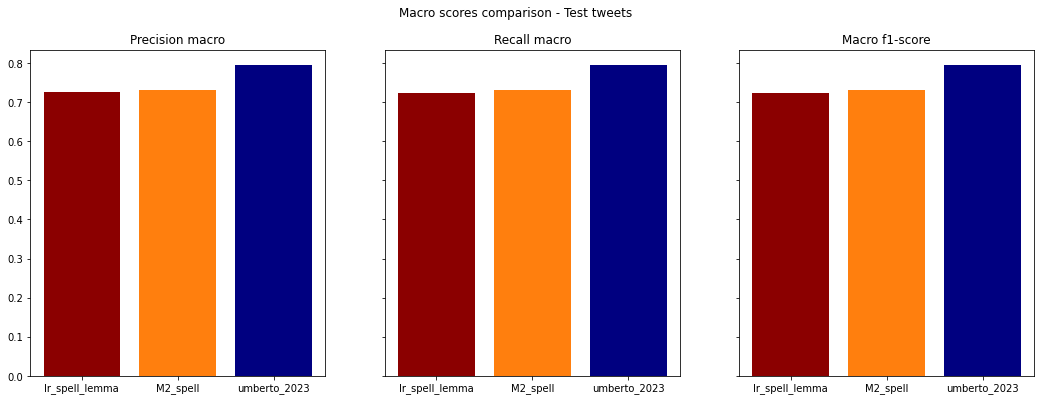

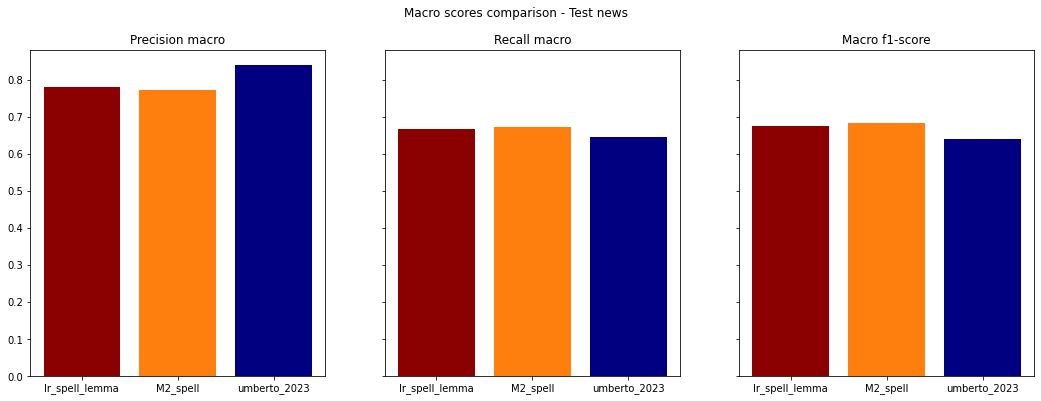

In [ ]:
pred_tweets_trans = trans_pred_tweets_hs_dict[best_trans_model]
pred_tweets_ml =  ml_pred_tweets_hs_dict[best_ml_model]
pred_tweets_rnn = rnn_pred_tweets_hs_dict[best_rnn_model]

prfs_trans = prfs(df_test_tweets['hate_speech'], pred_tweets_trans, average="macro")
prfs_ml = prfs(df_test_tweets['hate_speech'], pred_tweets_ml, average="macro")
prfs_rnn = prfs(df_test_tweets['hate_speech'], pred_tweets_rnn, average="macro")

fig, plots = plt.subplots(1,3, sharey=True, figsize=(18, 6))
fig.suptitle('Macro scores comparison - Test tweets')
plots[0].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[0], prfs_rnn[0], prfs_trans[0]], color=["darkred", "tab:orange", "navy"])
plots[0].set_title("Precision macro")
plots[1].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[1], prfs_rnn[1], prfs_trans[1]], color=["darkred", "tab:orange", "navy"])
plots[1].set_title("Recall macro")
plots[2].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[2], prfs_rnn[2], prfs_trans[2]], color=["darkred", "tab:orange", "navy"])
plots[2].set_title("Macro f1-score")

plt.show()

print()

pred_news_trans = trans_pred_news_hs_dict[best_trans_model]
pred_news_ml =  ml_pred_news_hs_dict[best_ml_model]
pred_news_rnn = rnn_pred_news_hs_dict[best_rnn_model]

prfs_trans = prfs(df_test_news['hate_speech'], pred_news_trans, average="macro")
prfs_ml = prfs(df_test_news['hate_speech'], pred_news_ml, average="macro")
prfs_rnn = prfs(df_test_news['hate_speech'], pred_news_rnn, average="macro")

fig, plots = plt.subplots(1,3, sharey=True, figsize=(18, 6))
fig.suptitle('Macro scores comparison - Test news')
plots[0].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[0], prfs_rnn[0], prfs_trans[0]], color=["darkred", "tab:orange", "navy"])
plots[0].set_title("Precision macro")
plots[1].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[1], prfs_rnn[1], prfs_trans[1]], color=["darkred", "tab:orange", "navy"])
plots[1].set_title("Recall macro")
plots[2].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[2], prfs_rnn[2], prfs_trans[2]], color=["darkred", "tab:orange", "navy"])
plots[2].set_title("Macro f1-score")

plt.show()

Given the same test set type, results of the three best models are fully comparable. However, while there is no significant difference between precision, recall and f1-score of models on test tweets, on test news they show an higher precision, at the expense of low recall and macro f1-score.

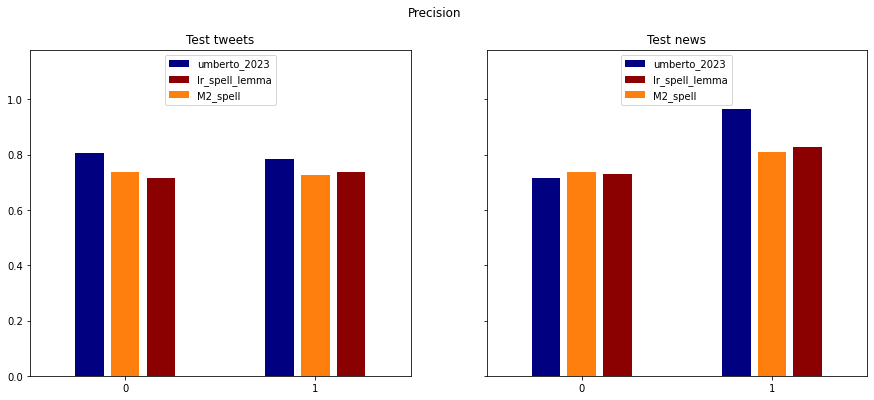

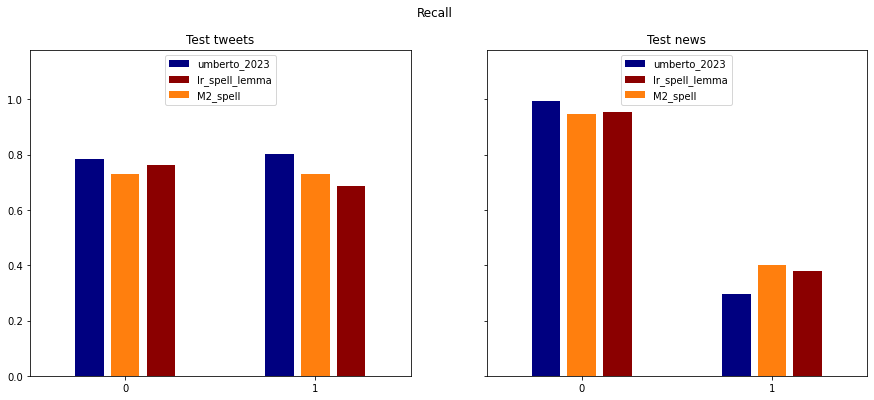

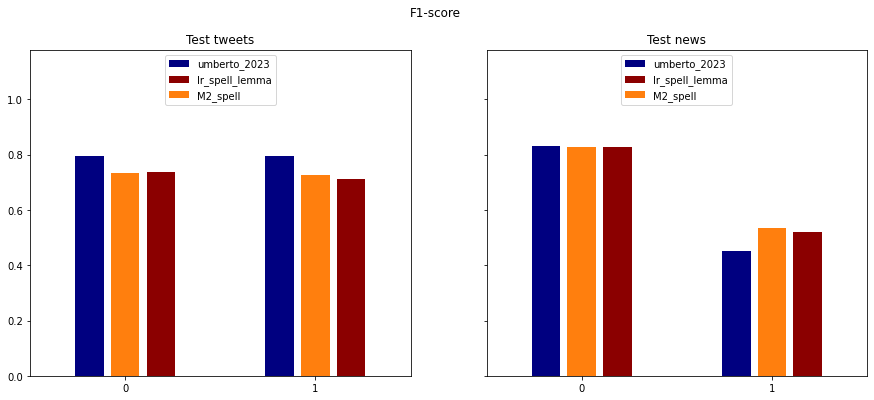

In [ ]:
prfs_1 = prfs(df_test_tweets['hate_speech'], pred_tweets_trans, labels=[0,1], average=None, zero_division=0)
prfs_2 = prfs(df_test_tweets['hate_speech'], pred_tweets_ml, labels=[0,1], average=None, zero_division=0)
prfs_3 = prfs(df_test_tweets['hate_speech'], pred_tweets_rnn, labels=[0,1], average=None, zero_division=0)

prfs_4 = prfs(df_test_news['hate_speech'], pred_news_trans, labels=[0,1], average=None, zero_division=0)
prfs_5 = prfs(df_test_news['hate_speech'], pred_news_ml, labels=[0,1], average=None, zero_division=0)
prfs_6 = prfs(df_test_news['hate_speech'], pred_news_rnn, labels=[0,1], average=None, zero_division=0)

width=0.15

ids = np.arange(0,2)
x_labels = [0, 1]

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('Precision')
ax[0].bar(ids-5/4*width, prfs_1[0], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[0], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[0], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[0], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[0], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[0], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')


plt.show()
print()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('Recall')
ax[0].bar(ids-5/4*width, prfs_1[1], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[1], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[1], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[1], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[1], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[1], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

plt.show()
print()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('F1-score')
ax[0].bar(ids-5/4*width, prfs_1[2], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[2], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[2], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[2], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[2], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[2], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

plt.show()

For each model, the per-class precision, recall and f1-score on test tweets are quite consistent with the macro ones, while it is not the case for test news. Indeed, the per-class recall and f1-score of all models on test news are higher on the class $0$ than on the class $1$, which they struggle a lot to classify correctly. On the other hand, precision is higher on the class $1$ than on class $0$.  
This could be influenced by the slight skewing of the training data towards the class $0$, but it's more likely due to the difficulty of identifying hate speech within a different type of language than that used for training.

### Confusion matrices

As a further analysis, let's visualize the confusion matrices for all the models, both on tweets and news test sets.

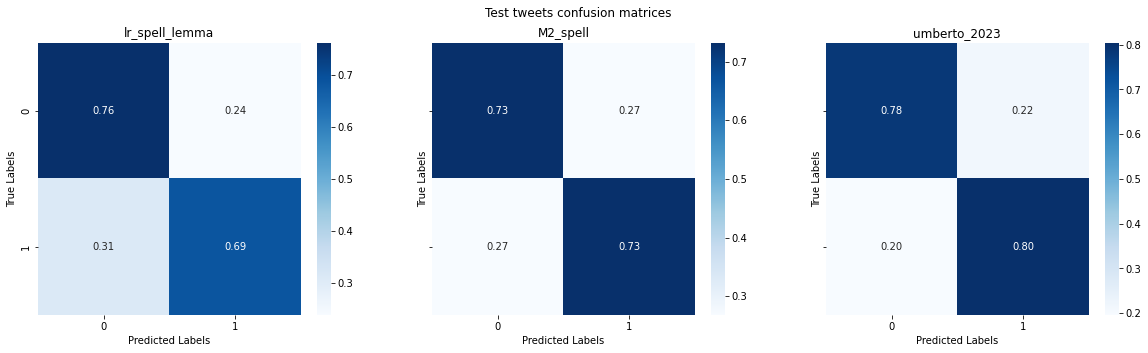

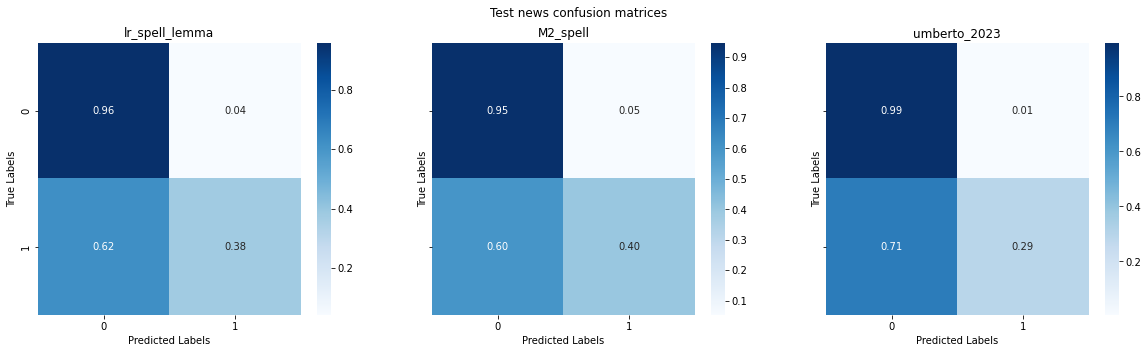

In [ ]:
fig, axn = plt.subplots(1,3, sharey=True, figsize=(20, 5))

fig.suptitle('Test tweets confusion matrices')

c1 = confusion_matrix(df_test_tweets['hate_speech'], pred_tweets_ml, normalize='true', labels=[0,1])
h1 = sns.heatmap(c1, annot = True, fmt = '.2f', ax = axn.flat[0], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h1.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[0].set_title(best_ml_model, fontsize=12)

c2 = confusion_matrix(df_test_tweets['hate_speech'], pred_tweets_rnn, normalize='true', labels=[0,1])
h2 = sns.heatmap(c2, annot = True, fmt = '.2f', ax = axn.flat[1], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h2.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[1].set_title(best_rnn_model, fontsize=12)

c3 = confusion_matrix(df_test_tweets['hate_speech'], pred_tweets_trans, normalize='true', labels=[0,1])
h3 = sns.heatmap(c3, annot = True, fmt = '.2f', ax = axn.flat[2], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h3.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[2].set_title(best_trans_model, fontsize=12)

plt.show()


print()


fig, axn = plt.subplots(1,3, sharey=True, figsize=(20, 5))

fig.suptitle('Test news confusion matrices')

c1 = confusion_matrix(df_test_news['hate_speech'], pred_news_ml, normalize='true', labels=[0,1])
h1 = sns.heatmap(c1, annot = True, fmt = '.2f', ax = axn.flat[0], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h1.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[0].set_title(best_ml_model, fontsize=12)


c2 = confusion_matrix(df_test_news['hate_speech'], pred_news_rnn, normalize='true', labels=[0,1])
h2 = sns.heatmap(c2, annot = True, fmt = '.2f', ax = axn.flat[1], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h2.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[1].set_title(best_rnn_model, fontsize=12)

c3 = confusion_matrix(df_test_news['hate_speech'], pred_news_trans, normalize='true', labels=[0,1])
h3 = sns.heatmap(c3, annot = True, fmt = '.2f', ax = axn.flat[2], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h3.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[2].set_title(best_trans_model, fontsize=12)

plt.show()

From those plots it is even clearer that models really struggle in identifying correctly news containing hate speech.

### Specific errors analysis

Let's now have a deeper look into samples which are completely misclassified by all models.

First, it can be useful to print some statistics about the most frequent words in all the sets.

In [ ]:
def most_frequent_words(df, n_print, split):

  """
    After applying basic pre-processing and removing stopwords, it finds the most frequent words in the given DataFrame and prints the top `n_print` words.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the text data.
    - n_print (int): The number of most frequent words to be printed.
    - split (str): The name of the split to be included in the output.

    Returns:
    - list: A list of tuples, where each tuple contains a word and its frequency, sorted in descending order of frequency.

  """

  wordcount = {}

  prova = df['text'].copy()
  prova = cleaning_text(prova)
  prova = remove_stopwords(prova)

  for p in prova:
    for word in p.lower().split():
        if word != 'non':
          if word not in wordcount:
              wordcount[word] = 1
          else:
              wordcount[word] += 1

  print("\n{} SET".format(split))
  word_counter = collections.Counter(wordcount)
  for word, count in word_counter.most_common(n_print):
      print(word, ": ", count)
  print()

  return word_counter.most_common(n_print)

In [ ]:
df_train_hs_1 = df_train[df_train['hate_speech']==1].copy()
df_val_hs_1 = df_val[df_val['hate_speech']==1].copy()
df_test_tweets_hs_1 = df_test_tweets[df_test_tweets['hate_speech']==1].copy()
df_test_news_hs_1 = df_test_news[df_test_news['hate_speech']==1].copy()

n_print = 10
print(f"Most {n_print} common words among all the tweets/news marked as hate speech, for each set:")

train_wc_hs_1 = most_frequent_words(df_train_hs_1, n_print, 'TRAINING')
val_wc_hs_1 = most_frequent_words(df_val_hs_1, n_print, 'VALIDATION')
test_tweets_wc_hs_1 = most_frequent_words(df_test_tweets_hs_1, n_print, 'TWEETS TEST')
test_news_wc_hs_1 = most_frequent_words(df_test_news_hs_1, n_print, 'NEWS TEST')

Most 10 common words among all the tweets/news marked as hate speech, for each set:

TRAINING SET
immigrati :  420
migranti :  372
italiani :  279
rom :  278
italia :  245
casa :  181
stranieri :  172
solo :  156
clandestini :  154
islamici :  153


VALIDATION SET
migranti :  111
immigrati :  100
rom :  72
italia :  60
italiani :  55
clandestini :  54
terroristi :  52
casa :  45
fare :  43
basta :  40


TWEETS TEST SET
migranti :  132
immigrati :  113
rom :  94
italiani :  86
casa :  86
lislam :  74
solo :  64
italia :  62
islam :  56
fare :  51


NEWS TEST SET
immigrati :  60
clandestini :  32
profughi :  28
ecco :  25
italia :  15
migranti :  15
italiani :  13
cosa :  12
così :  11
rom :  11



In [ ]:
df_train_hs_0 = df_train[df_train['hate_speech']==0].copy()
df_val_hs_0 = df_val[df_val['hate_speech']==0].copy()
df_test_tweets_hs_0 = df_test_tweets[df_test_tweets['hate_speech']==0].copy()
df_test_news_hs_0 = df_test_news[df_test_news['hate_speech']==0].copy()

n_print = 10
print(f"Most {n_print} common words among all the tweets/news not marked as hate speech, for each set:")

train_wc_hs_0 = most_frequent_words(df_train_hs_0, n_print, 'TRAINING')
val_wc_hs_0 = most_frequent_words(df_val_hs_0, n_print, 'VALIDATION')
test_tweets_wc_hs_0 = most_frequent_words(df_test_tweets_hs_0, n_print, 'TWEETS TEST')
test_news_wc_hs_0 = most_frequent_words(df_test_news_hs_0, n_print, 'NEWS TEST')

Most 10 common words among all the tweets/news not marked as hate speech, for each set:

TRAINING SET
rom :  932
migranti :  613
roma :  427
immigrati :  347
italia :  269
campo :  241
nomadi :  207
italiani :  194
via :  189
stranieri :  181


VALIDATION SET
rom :  243
migranti :  166
roma :  112
immigrati :  77
italia :  62
campo :  58
stranieri :  54
italiani :  53
via :  49
solo :  46


TWEETS TEST SET
migranti :  259
rom :  137
immigrati :  92
italia :  71
italiani :  68
salvini :  60
solo :  57
ong :  39
torremaura :  39
anni :  38


NEWS TEST SET
migranti :  178
salvini :  60
sea :  32
immigrati :  32
watch :  29
rom :  26
maio :  15
matteo :  14
immigrazione :  14
fa :  12



In [ ]:
train_hs_1 = [train_wc_hs_1[i][0] for i in range(0, len(train_wc_hs_1))]
train_hs_0 = [train_wc_hs_0[i][0] for i in range(0, len(train_wc_hs_0))]

The most informative words are those that appear frequently in train tweets belonging to one class, but not in those of the other.

In [ ]:
print("Words that are frequent in hate speech train tweets but not in non-hate speech ones:")
words_hs = [w for w in train_hs_1 if w not in train_hs_0]
words_hs

Words that are frequent in hate speech train tweets but not in non-hate speech ones:


['casa', 'solo', 'clandestini', 'islamici']

In [ ]:
print("Words that are frequent in non-hate speech train tweets but not in hate speech ones:")
words_not_hs = [w for w in train_hs_0 if w not in train_hs_1]
words_not_hs

Words that are frequent in non-hate speech train tweets but not in hate speech ones:


['roma', 'campo', 'nomadi', 'via']

#### Tweets

For the purpose of analysis, it is needed to retrieve best models predictions.

Also, it might be useful to visualize which kind of input the models have been fed with. So, let's also retrieve the pre-processed inputs, according to the models under analysis.

In [ ]:
if 'spell_lemma' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=True, labels = 'hate_speech')
elif 'spell' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=False, labels = 'hate_speech')
elif 'lemma' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=True, labels = 'hate_speech')
else:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=False, labels = 'hate_speech')


if 'spell_lemma' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=True, labels = 'hate_speech')
elif 'spell' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=False, labels = 'hate_speech')
elif 'lemma' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=True, labels = 'hate_speech')
else:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=False, labels = 'hate_speech')

For conveniency reasons, all predictions and preprocessed tweets are collected in a single dataframe, which contains also original tweets and true HS labels.

In [ ]:
df_analysis = df_test_tweets.copy()

df_analysis['pred_rnn'] = pred_tweets_rnn
df_analysis['pred_ml'] = pred_tweets_ml
df_analysis['pred_trans'] = pred_tweets_trans
df_analysis['clean_tweets_ml'] = clean_tweets_ml
df_analysis['clean_tweets_rnn'] = clean_tweets_rnn

df_analysis = df_analysis.drop(['clean_text', 'stereotype'], axis=1)
df_analysis

,id,text,hate_speech,pred_rnn,pred_ml,pred_trans,clean_tweets_ml,clean_tweets_rnn
0,11834,@user A me pare una scelta politica suicida pu...,1,0,0,0,me parere scelta politica suicidare puntare ba...,me pare scelta politica suicida puntare battag...
1,12113,@user e' un perfetto musulmano!!! chi dice il ...,1,0,1,1,perfetto musulmano dire contrario mente applic...,perfetto musulmano dice contrario mente applic...
2,11770,Mai Tg e i giornaloni hanno parlato di questa ...,1,1,0,1,mai tg giornalino parlare ennesima porcatare f...,mai tg giornalini parlato ennesima porcata fat...
3,11937,@user Ipocriti farabutti. Fanno morire i terre...,1,1,1,1,ipocrito farabutto morire terremotato bastardo...,ipocriti farabutti morire terremotati bastardi...
4,11870,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1,1,1,1,immigrazione ce stare calo fisiologico rinpatr...,immigrazione ce stato calo fisiologico rinpatr...
...,...,...,...,...,...,...,...,...
1258,10091,Il Razzismo gli viene inculcato sin da bambini...,1,1,1,1,razzismo venire inculcare sin bambino corare d...,razzismo viene inculcato sin bambini corano da...
1259,10046,PERCHÉ DI QUESTO ORRENDO STUPRO NON DI PARLA? ...,1,0,1,1,orrere stupro non parlare informazione corrott...,orrendo stupro non parla informazione corrotta...
1260,10377,FERMIAMO L'IMPOSTORE. Forse saranno necesarie ...,1,1,1,1,fermare impostora forse necessaria altra croci...,fermiamo impostore forse necessarie altre croc...
1261,10199,@user @user @user @user @user @user @user @use...,1,1,1,1,matteo non toccafuore delinquento straniero casa,matteo non toccafuori delinquenti stranieri casa


Now let's select only those samples that are misclassified by all models under analysis.

In [ ]:
df_all_wrong = df_analysis[(df_analysis['pred_rnn']==df_analysis['pred_ml']) & (df_analysis['pred_rnn']==df_analysis['pred_trans']) & (df_analysis['hate_speech']!=df_analysis['pred_ml'])]
df_all_wrong = df_all_wrong.reset_index(drop=True)
df_all_wrong

,id,text,hate_speech,pred_rnn,pred_ml,pred_trans,clean_tweets_ml,clean_tweets_rnn
0,11834,@user A me pare una scelta politica suicida pu...,1,0,0,0,me parere scelta politica suicidare puntare ba...,me pare scelta politica suicida puntare battag...
1,12224,Quelli che dicono io non sto con #Salvini perc...,1,0,0,0,dire non salvino non razzista sapere usare mer...,dicono non salvini non razzista sanno usare mo...
2,12026,@user @user Dopo la sfida a #UE #Malta #Italia...,1,0,0,0,dopo sfida ue malta italia criminala seawatch3...,dopo sfida ue malta italia criminale seawatch3...
3,12258,"#Monfalcone (GO), Giunta di CDX sta scoprendo ...",1,0,0,0,monfalcona go giunta cdx scoprire centinaia ir...,monfalcone go giunta cdx scoprendo centinaia i...
4,11570,#Emergenza #morbillo e #meningite in #Italia c...,1,0,0,0,emergenza morbillo meningite italia conseguenz...,emergenza morbillo meningite italia conseguenz...
...,...,...,...,...,...,...,...,...
110,10750,@user Sottovalutare L'Islam è una condanna a m...,0,1,1,1,sottovalutare lislam condanna morte,sottovalutare lislam condanna morte
111,10666,L’#Italia è quel paese dove le mucche vengono ...,0,1,1,1,litalia quel paese mucca venire massaggiare ru...,litalia quel paese mucche vengono massaggiare ...
112,10292,@user @user @user Se dipendesse dagli stronzi ...,0,1,1,1,dipendere stronzo stare andarsene rovina forza...,dipendesse stronzi stato andrebbe rovina forza...
113,10008,Ma perché tutta l'indignazione che vedo e sent...,0,1,1,1,tutta indignazione vedere sentire gg musulmano...,tutta indignazione vedo sento gg musulmani ebr...


Then only print some of those that do not contain hate speech (whose HS label is $0$).

In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==0]
sample = sample.reset_index(drop=True)

n = 23

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['hate_speech'], '\n')
  print('ML input:', sample.loc[i]['clean_tweets_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


LA SENSAZIONE E' QUELLA DI UN MALANNO INCOMBENTE CHE STA PER CONCLAMARSI: C'è PERICOLO IN ITALIA DI UN GOLPE ORDITO DALLA MAGISTRATURA PD E ALLEATI VARI, STAMPA, VATICANO, TV E, DIETRO, MA NON CELATA, LA MANO DELL'ISLAM ITALIANO SOSTENUTO DA EUROPA E PAESI ARABI.
True label: 0 

ML input: sensazione malanno incombenta conclamarsi cè pericolo italia golpe ordire magistratura pd alleato vario stampa vaticano tv dietro non celatare mano dellislam italiano sostenere europa paese arabo
ML prediction: 1 

RNN input: sensazione malanno incombente conclamarsi cè pericolo italia golpe ordito magistratura pd alleati vari stampa vaticano tv dietro non celata mano dellislam italiano sostenuto europa paesi arabi
RNN prediction: 1 

Transformer input: LA SENSAZIONE E' QUELLA DI UN MALANNO INCOMBENTE CHE STA PER CONCLAMARSI: C'è PERICOLO IN ITALIA DI UN GOLPE ORDITO DALLA MAGISTRATURA PD E ALLEATI VARI, STAMPA, VATICANO, TV E, DIETRO, MA NON CELATA, LA MANO DELL'ISLAM ITALIANO SOSTENUTO DA EUROPA E 

Now instead only print some of those that actually contain hate speech (whose HS label is $1$).

In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==1]
sample = sample.reset_index(drop=True)
n = 23

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['hate_speech'], '\n')
  print('ML input:', sample.loc[i]['clean_tweets_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


I SOLDI DEI DISABILI AI MIGRANTI La regione Emilia Romagna destina la metà dei fondi destinati alle fasce deboli a progetti per i richiedenti asilo A Reggio Emilia il 69% delle risorse stanziate sono state utilizzate ai richiedenti asilo #PRIMAGLIITALIANI  URL
True label: 1 

ML input: soldi disabile migrante regione emilia romagna destinare metà fondi destinatare fasca debolo progetti richiedento asilo reggio emilia 69 risorsa stanzare stare utilizzare richiedento asilo primagliitaliano
ML prediction: 0 

RNN input: soldi disabili migranti regione emilia romagna destina metà fondi destinati fasce deboli progetti richiedenti asilo reggio emilia 69 risorse stanziate state utilizzate richiedenti asilo primagliitaliani
RNN prediction: 0 

Transformer input: I SOLDI DEI DISABILI AI MIGRANTI La regione Emilia Romagna destina la metà dei fondi destinati alle fasce deboli a progetti per i richiedenti asilo A Reggio Emilia il 69% delle risorse stanziate sono state utilizzate ai richiedenti as

Looking deeper into misclassified samples from all models, some interesting possible causes of error have emerged.

For example, it's really hard for models to detect hate speech in tweets where the hate message is somehow only implied and the meaning is hidden behind nuance of the language. Therefore, tweets such as:


In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==1]
sample = sample.reset_index(drop=True)
i = 23

print(sample.loc[i]['text'])
print('True label:', sample.loc[i]['hate_speech'], '\n')
print('ML input:', sample.loc[i]['clean_tweets_ml'])
print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
print("Transformer input:", sample.loc[i]['text'])
print("Transformer prediction:", sample.loc[i]['pred_trans'])

I SOLDI DEI DISABILI AI MIGRANTI La regione Emilia Romagna destina la metà dei fondi destinati alle fasce deboli a progetti per i richiedenti asilo A Reggio Emilia il 69% delle risorse stanziate sono state utilizzate ai richiedenti asilo #PRIMAGLIITALIANI URL
True label: 1 

ML input: soldi disabile migrante regione emilia romagna destinare metà fondi destinatare fasca debolo progetti richiedento asilo reggio emilia 69 risorsa stanzare stare utilizzare richiedento asilo primagliitaliano 
ML prediction: 0 

RNN input: soldi disabili migranti regione emilia romagna destina metà fondi destinati fasce deboli progetti richiedenti asilo reggio emilia 69 risorse stanziate state utilizzate richiedenti asilo primagliitaliani 
RNN prediction: 0 

Transformer input: I SOLDI DEI DISABILI AI MIGRANTI La regione Emilia Romagna destina la metà dei fondi destinati alle fasce deboli a progetti per i richiedenti asilo A Reggio Emilia il 69% delle risorse stanziate sono state utilizzate ai richiedenti as

might often be misclassified. \\

Some errors could also be due to a too heavy pre-processing, which, even if careful, could sometimes change the meaning of the sentence. \\

Finally, it's interesting to note that the models often misclassify tweets/news containing hate speech but aimed at non-Muslims, Immigrates or Roma targets, whose ground truth is therefore $0$, as for example:

In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==0]
sample = sample.reset_index(drop=True)
i = 25

print(sample.loc[i]['text'])
print('True label:', sample.loc[i]['hate_speech'], '\n')
print('ML input:', sample.loc[i]['clean_tweets_ml'])
print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
print("Transformer input:", sample.loc[i]['text'])
print("Transformer prediction:", sample.loc[i]['pred_trans'])

@user @user L'esatto contrario di quello che sistematicamente fanno da anni i sindaci di sinistra, per loro prima gli immigrati. Mi raccomando votate ancora questi imbecilli di sinistra, come casa vi ritroverete la vostra bella macchina.
True label: 0 

ML input: esatto contrario sistematicamente anno sindaco sinistra prima immigrati raccomare votare ancora imbecillo sinistra casa ritrovare bella macchina
ML prediction: 1 

RNN input: esatto contrario sistematicamente anni sindaci sinistra prima immigrati raccomando votate ancora imbecilli sinistra casa ritroverete bella macchina
RNN prediction: 1 

Transformer input: @user @user L'esatto contrario di quello che sistematicamente fanno da anni i sindaci di sinistra, per loro prima gli immigrati. Mi raccomando votate ancora questi imbecilli di sinistra, come casa vi ritroverete la vostra bella macchina.
Transformer prediction: 1


This shows that they have learned to understand the presence of hate speech but do not distinguish with respect to the target the message is are aimed at.

#### News

Then, the same analysis procedure goes for test news.

In [ ]:
if 'spell_lemma' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=True, lemma=True, labels = 'hate_speech')
elif 'spell' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=True, lemma=False, labels = 'hate_speech')
elif 'lemma' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=False, lemma=True, labels = 'hate_speech')
else:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=False, lemma=False, labels = 'hate_speech')

if 'spell_lemma' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=True, lemma=True, labels = 'hate_speech')
elif 'spell' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=True, lemma=False, labels = 'hate_speech')
elif 'lemma' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=False, lemma=True, labels = 'hate_speech')
else:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=False, lemma=False, labels = 'hate_speech')

In [ ]:
df_analysis = df_test_news.copy()

df_analysis['pred_rnn'] = pred_news_rnn
df_analysis['pred_ml'] = pred_news_ml
df_analysis['pred_trans'] = pred_news_trans
df_analysis['clean_news_ml'] = clean_news_ml
df_analysis['clean_news_rnn'] = clean_news_rnn

df_analysis = df_analysis.drop(['clean_text', 'stereotype'], axis=1)
df_analysis

,id,text,hate_speech,pred_rnn,pred_ml,pred_trans,clean_news_ml,clean_news_rnn
0,12142,Che fine spero che faccia il killer nigeriano ...,1,1,0,0,fine sperare killer nigeriano pamelare furia c...,fine spero killer nigeriano pamela furia cieca...
1,12088,Così i profughi ci svuotano i negozi a Pordenone,1,0,0,1,così profugo svuotare negozio pordenona,così profughi svuotano negozi pordenone
2,12030,Così umiliano gli italiani e coccolano i cland...,1,1,1,1,così umiliare italiano coccolare clandestino f...,così umiliano italiani coccolano clandestini f...
3,11775,"Danno soldi ai clandestini, ma ai disabili inv...",1,1,1,0,danno soldi clandestino disabile invece bracco...,danno soldi clandestini disabili invece bracco...
4,11630,"Emergenza, Minniti annulla il viaggio e torna ...",1,0,0,0,emergenza minnito annullare viaggio tornare it...,emergenza minniti annulla viaggio torna italia...
...,...,...,...,...,...,...,...,...
494,10085,"Sea Watch, il pm fa sbarcare i migranti. Salvi...",0,0,0,0,sea watch pm farsene sbarcare migrante salvino...,sea watch pm fa sbarcare migranti salvini denu...
495,10044,Il pm fa sbarcare i migranti Il capo leghista ...,0,0,0,0,pm farsene sbarcare migrante capo leghista sme...,pm fa sbarcare migranti capo leghista smentito tv
496,10602,"Pisa, il poster di Salvini con i migranti fatt...",0,0,0,0,pisa poster salvino migrante fatto studento ce...,pisa poster salvini migranti fatto studenti ce...
497,10193,Sea Watch e lo sbarco del migrante con una sol...,0,0,0,0,sea watch sbarco migranta sola gamba potere re...,sea watch sbarco migrante sola gamba possa rea...


In [ ]:
df_all_wrong = df_analysis[(df_analysis['pred_rnn']==df_analysis['pred_ml']) & (df_analysis['pred_rnn']==df_analysis['pred_trans']) & (df_analysis['hate_speech']!=df_analysis['pred_ml'])]
df_all_wrong = df_all_wrong.reset_index(drop=True)
df_all_wrong

,id,text,hate_speech,pred_rnn,pred_ml,pred_trans,clean_news_ml,clean_news_rnn
0,11630,"Emergenza, Minniti annulla il viaggio e torna ...",1,0,0,0,emergenza minnito annullare viaggio tornare it...,emergenza minniti annulla viaggio torna italia...
1,11663,"Immigrati, così la sinistra ci costringe a ten...",1,0,0,0,immigrati così sinistra costringere tenerlare ...,immigrati così sinistra costringe tenerli melo...
2,12108,Malaria? E' solo l'inizio.... La tremenda prof...,1,0,0,0,malaria solo linizio tremenda profezia leghist...,malaria solo linizio tremenda profezia leghist...
3,11897,Atti osceni davanti ai bambini: il parco di Mi...,1,0,0,0,atto osceno davanti bambino parco milare balìa...,atti osceni davanti bambini parco milano balìa...
4,11251,"Sea Watch, l'ultima presa in giro degli immigr...",1,0,0,0,sea watch lultima presare giro immigrati allit...,sea watch lultima presa giro immigrati allital...
...,...,...,...,...,...,...,...,...
78,10729,"Immigrazione, la ricetta di Frattini: ""Chiuder...",1,0,0,0,immigrazione ricetta frattino chiudere porti,immigrazione ricetta frattini chiudere porti
79,10247,"Immigrazione, la rotta dei sospetti jihadisti:...",1,0,0,0,immigrazione rotta sospetto jihadire italia mo...,immigrazione rotta sospetti jihadisti italia m...
80,10259,In Porta Venezia i negozi chiudono per colpa d...,1,0,0,0,portare venezia negozio chiudere colpa profugo,porta venezia negozi chiudono colpa profughi
81,10262,"Italia, la terrificante verità sulla mafia nig...",1,0,0,0,italia terrificanta verità mafia nigeriana col...,italia terrificante verità mafia nigeriana col...


In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==0]
sample = sample.reset_index(drop=True)

n = 0

for i in range(n, n+2):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['hate_speech'], '\n')
  print('ML input:', sample.loc[i]['clean_news_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_news_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


Salvini contestato a Giulianova: "Assassino di m...". E lui replica: "Hai vinto dieci immigrati a casa tua"
True label: 0 

ML input: salvino contestare giulianova assassino m replica vincere dieci immigrati casa
ML prediction: 1 

RNN input: salvini contestato giulianova assassino m replica vinto dieci immigrati casa
RNN prediction: 1 

Transformer input: Salvini contestato a Giulianova: "Assassino di m...". E lui replica: "Hai vinto dieci immigrati a casa tua"
Transformer prediction: 1

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

“I 

In [ ]:
sample = df_all_wrong[df_all_wrong['hate_speech']==1]
sample = sample.reset_index(drop=True)

n = 23

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['hate_speech'], '\n')
  print('ML input:', sample.loc[i]['clean_news_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_news_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


Ecco la notizia più attesa. Immigrati, il dato pazzesco: in Italia adesso cambia tutto?
True label: 1 

ML input: ecco notizia attesa immigrati datare pazzesco italia adesso cambiare
ML prediction: 0 

RNN input: ecco notizia attesa immigrati dato pazzesco italia adesso cambia
RNN prediction: 0 

Transformer input: Ecco la notizia più attesa. Immigrati, il dato pazzesco: in Italia adesso cambia tutto?
Transformer prediction: 0

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ecco perché i migranti saranno sempre di più e l'Italia perde la 

It can be clearly seen how the news usually contains messages of hate expressed differently than tweets, where the message is more explicit and less nuanced. In addition, the news uses different language and style, on which the models have not been trained. Therefore, these might be possible causes of models poor performances on test news.

## Task B

### Best models selection

In [ ]:
def models_rank(model_type, scores_dict, models_dict):

  """
    Prints macro f1-scores for the given models.

    Parameters:
    - model_type (str): The type of the models.
    - scores_dict (dict): A dictionary containing the evaluation results for each model.
    - models_dict (dict): A dictionary containing the models.

    Returns:
    - f1_scores_macro_dict (dict): A dictionary containing the macro f1-scores of each model.
  """


  f1_scores_macro_dict = {}
  rows = [[f'{model_type} model','macro f1-score'],['','']]

  for model in models_dict.keys():
    f1_scores_macro_dict[model] = scores_dict[model]['macro avg']['f1-score']
    rows.append([model, scores_dict[model]['macro avg']['f1-score']])

  lens = []
  for col in zip(*rows):
      lens.append(max([len(str(v)) for v in col]))
  format = "  ".join(["{:<" + str(l) + "}" for l in lens])

  for row in rows:
      print(format.format(*row))

  return f1_scores_macro_dict

First, let's print the macro f1-score of all models on the test tweets.

In [ ]:
trans_f1_macro_dict = models_rank('Transformer', trans_scores_st_dict, trans_models_st_dict)
print()
ml_f1_macro_dict = models_rank('Classic ML', ml_scores_st_dict, ml_models_st_dict)
print()
rnn_f1_macro_dict = models_rank('RNN', rnn_scores_st_dict, rnn_models_st_dict)

Transformer model  macro f1-score    
                                     
umberto_42         0.7524288679690994
umberto_2023       0.7428280542986425
distilbert_42      0.6943460815047022
distilbert_2023    0.6712779548107142

Classic ML model  macro f1-score    
                                    
svc               0.6878312255344776
svc_spell         0.6862466124661246
svc_lemma         0.6980639696308961
svc_spell_lemma   0.6927099793820639
lr                0.7047663452207666
lr_spell          0.6983829148471616
lr_lemma          0.7164589849661991
lr_spell_lemma    0.712647908716491 

RNN model       macro f1-score    
                                  
M1              0.7014137588301137
M2              0.6957283317356193
M1_spell        0.7014676737474553
M2_spell        0.696791101055807 
M1_lemma        0.6916621951104711
M2_lemma        0.7113121043653695
M1_spell_lemma  0.6967347494058251
M2_spell_lemma  0.7051874520650336


Then, let's order them by macro f1-score for selecting only the best one per model type.

In [ ]:
sorted_f1_scores_rnn = sorted(rnn_f1_macro_dict, key=rnn_f1_macro_dict.get, reverse=True)
sorted_f1_scores_trans = sorted(trans_f1_macro_dict, key=trans_f1_macro_dict.get, reverse=True)
sorted_f1_scores_ml = sorted(ml_f1_macro_dict, key=ml_f1_macro_dict.get, reverse=True)

best_rnn_model = sorted_f1_scores_rnn[0]
best_trans_model = sorted_f1_scores_trans[0]
best_ml_model = sorted_f1_scores_ml[0]

print('According to the macro f1-score on the test set of tweets, the best Transformer model is:', best_trans_model)
print('According to the macro f1-score on the test set of tweets, the best classic ML model is:', best_ml_model)
print('According to the macro f1-score on the test set of tweets, the best RNN model is:', best_rnn_model)

According to the macro f1-score on the test set of tweets, the best Transformer model is: umberto_42
According to the macro f1-score on the test set of tweets, the best classic ML model is: lr_lemma
According to the macro f1-score on the test set of tweets, the best RNN model is: M2_lemma


### F1-score, precision and recall


In order to compare the best models results, it is useful to plot the macro f1-score, precision and recall obtained on both on the test tweets and the test news.

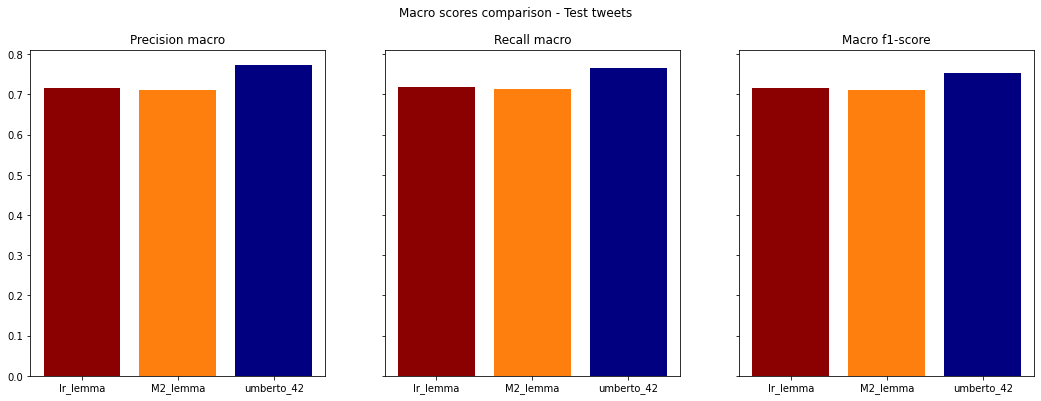

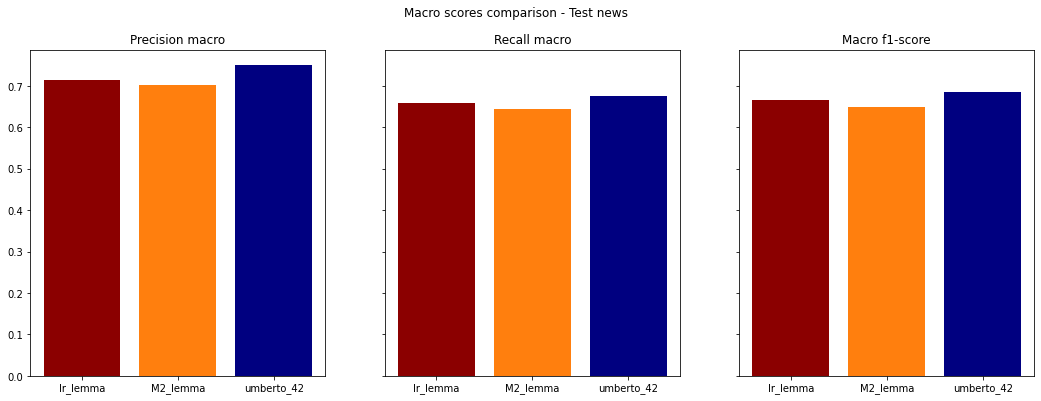

In [ ]:
pred_tweets_trans = trans_pred_tweets_st_dict[best_trans_model]
pred_tweets_ml =  ml_pred_tweets_st_dict[best_ml_model]
pred_tweets_rnn = rnn_pred_tweets_st_dict[best_rnn_model]

prfs_trans = prfs(df_test_tweets['stereotype'], pred_tweets_trans, average="macro")
prfs_ml = prfs(df_test_tweets['stereotype'], pred_tweets_ml, average="macro")
prfs_rnn = prfs(df_test_tweets['stereotype'], pred_tweets_rnn, average="macro")

fig, plots = plt.subplots(1,3, sharey=True, figsize=(18, 6))
fig.suptitle('Macro scores comparison - Test tweets')
plots[0].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[0], prfs_rnn[0], prfs_trans[0]], color=["darkred", "tab:orange", "navy"])
plots[0].set_title("Precision macro")
plots[1].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[1], prfs_rnn[1], prfs_trans[1]], color=["darkred", "tab:orange", "navy"])
plots[1].set_title("Recall macro")
plots[2].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[2], prfs_rnn[2], prfs_trans[2]], color=["darkred", "tab:orange", "navy"])
plots[2].set_title("Macro f1-score")

plt.show()

print()

pred_news_trans = trans_pred_news_st_dict[best_trans_model]
pred_news_ml =  ml_pred_news_st_dict[best_ml_model]
pred_news_rnn = rnn_pred_news_st_dict[best_rnn_model]

prfs_trans = prfs(df_test_news['stereotype'], pred_news_trans, average="macro")
prfs_ml = prfs(df_test_news['stereotype'], pred_news_ml, average="macro")
prfs_rnn = prfs(df_test_news['stereotype'], pred_news_rnn, average="macro")

fig, plots = plt.subplots(1,3, sharey=True, figsize=(18, 6))
fig.suptitle('Macro scores comparison - Test news')
plots[0].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[0], prfs_rnn[0], prfs_trans[0]], color=["darkred", "tab:orange", "navy"])
plots[0].set_title("Precision macro")
plots[1].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[1], prfs_rnn[1], prfs_trans[1]], color=["darkred", "tab:orange", "navy"])
plots[1].set_title("Recall macro")
plots[2].bar([best_ml_model, best_rnn_model, best_trans_model], [prfs_ml[2], prfs_rnn[2], prfs_trans[2]], color=["darkred", "tab:orange", "navy"])
plots[2].set_title("Macro f1-score")

plt.show()

Results of the three best models are again fully comparable, with no significant difference between precision, recall and f1-score of models for both test tweets and news.

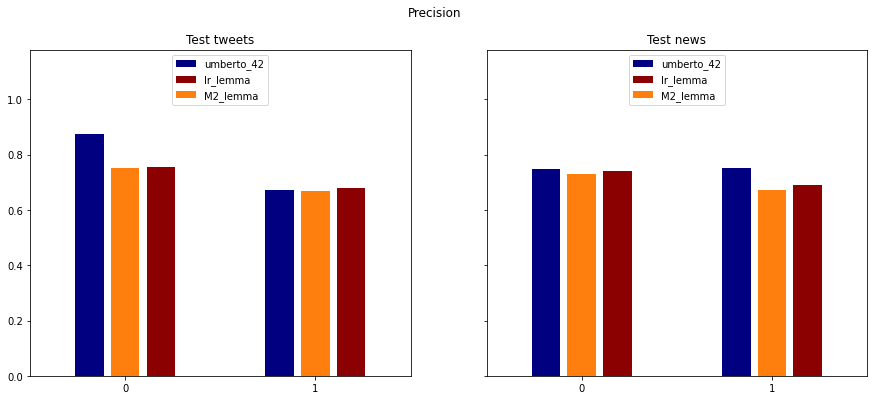

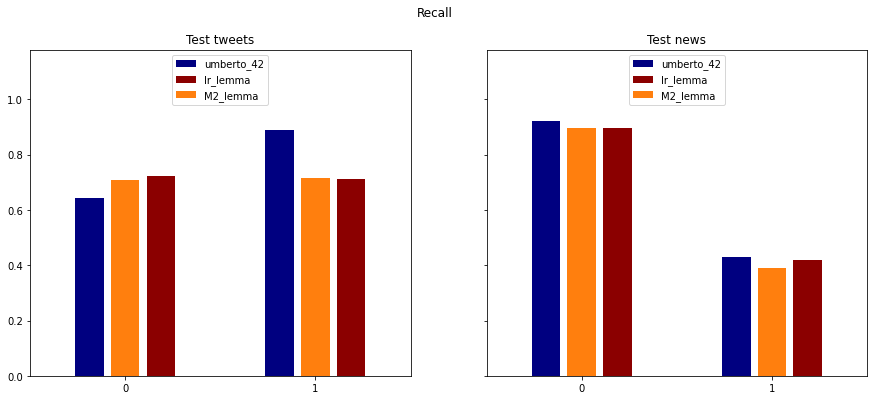

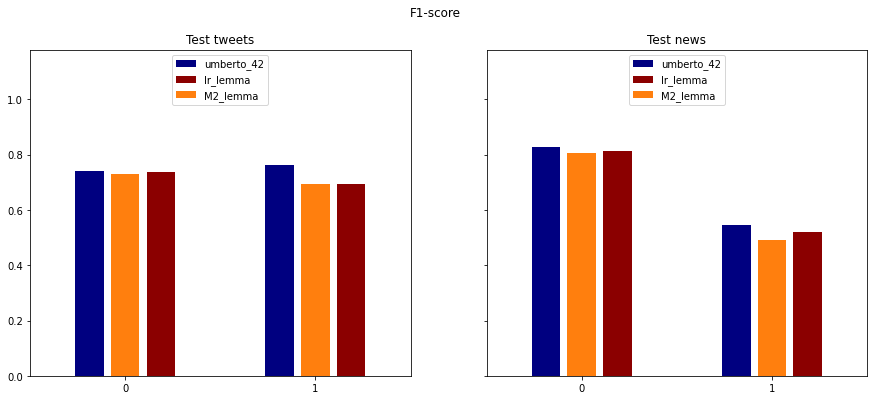

In [ ]:
prfs_1 = prfs(df_test_tweets['stereotype'], pred_tweets_trans, labels=[0,1], average=None, zero_division=0)
prfs_2 = prfs(df_test_tweets['stereotype'], pred_tweets_ml, labels=[0,1], average=None, zero_division=0)
prfs_3 = prfs(df_test_tweets['stereotype'], pred_tweets_rnn, labels=[0,1], average=None, zero_division=0)

prfs_4 = prfs(df_test_news['stereotype'], pred_news_trans, labels=[0,1], average=None, zero_division=0)
prfs_5 = prfs(df_test_news['stereotype'], pred_news_ml, labels=[0,1], average=None, zero_division=0)
prfs_6 = prfs(df_test_news['stereotype'], pred_news_rnn, labels=[0,1], average=None, zero_division=0)

width=0.15

ids = np.arange(0,2)
x_labels = [0, 1]

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('Precision')
ax[0].bar(ids-5/4*width, prfs_1[0], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[0], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[0], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[0], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[0], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[0], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')


plt.show()
print()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('Recall')
ax[0].bar(ids-5/4*width, prfs_1[1], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[1], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[1], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[1], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[1], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[1], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

plt.show()
print()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
fig.suptitle('F1-score')
ax[0].bar(ids-5/4*width, prfs_1[2], width, label=best_trans_model, color="navy")
ax[0].bar(ids+5/4*width, prfs_2[2], width, label=best_ml_model, color="darkred")
ax[0].bar(ids, prfs_3[2], width, label=best_rnn_model, color="tab:orange")
ax[0].set_title("Test tweets")
ax[1].bar(ids-5/4*width, prfs_4[2], width, label=best_trans_model, color="navy")
ax[1].bar(ids+5/4*width, prfs_5[2], width, label=best_ml_model, color="darkred")
ax[1].bar(ids, prfs_6[2], width, label=best_rnn_model, color="tab:orange")
ax[1].set_title("Test news")
ax[0].set_ylim([0,1.18])
ax[0].set_xlim([-0.5,1.5])
ax[0].set_xticks(ids)
ax[0].set_xticklabels(x_labels)
ax[1].set_ylim([0,1.18])
ax[1].set_xlim([-0.5,1.5])
ax[1].set_xticks(ids)
ax[1].set_xticklabels(x_labels)
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

plt.show()

Again, on test tweets each model shows consistency between the per-class precision, recall and f1-score and the macro ones. Only UmBERTo achieves on test tweets an high precision on class $0$, at the expense of a bad recall on the same class, while reaching an high recall on class $1$, but with a correspondent lower precision. \\


Also, models per-class recall and f1-score on test news are always higher on the class $0$ than on the class $1$, with a low precision on both classes. Likewise the hate speech detection task, this may be due to the slightly imbalanced nature of the training data towards the $0$ class, but the difference in the way the stereotype is expressed between the training tweets and the test news is what affects it most.


### Confusion matrices

As a further analysis, let's visualize the confusion matrices for all the models, both on tweets and news test sets.

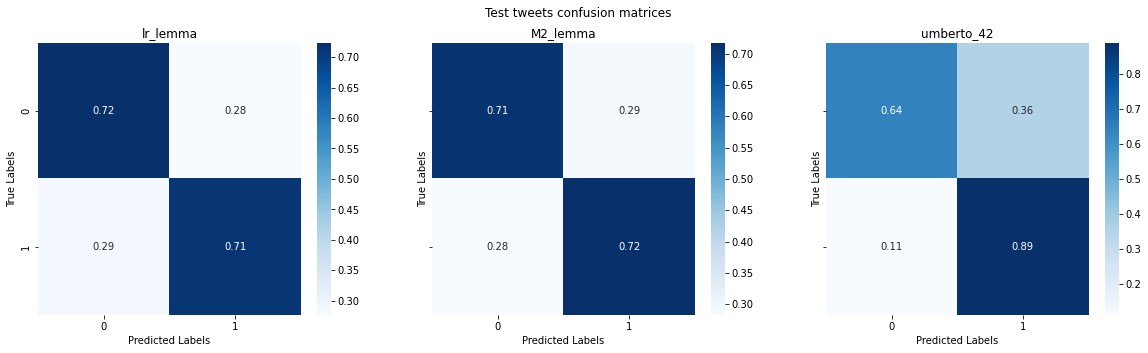

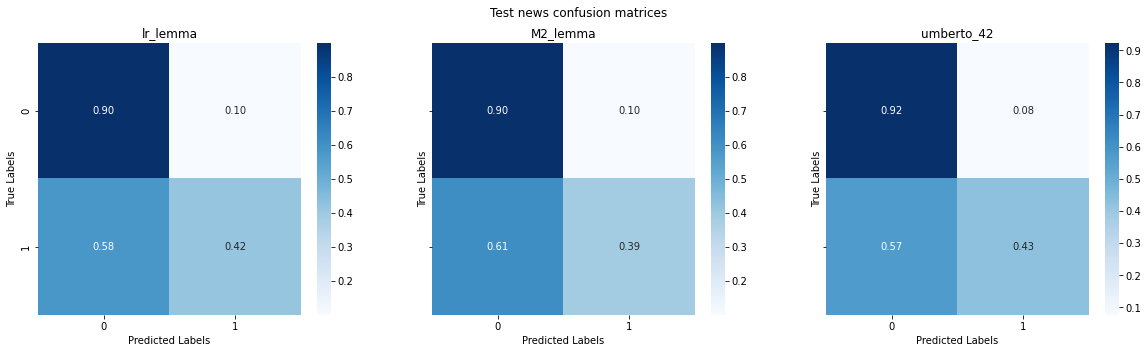

In [ ]:
fig, axn = plt.subplots(1,3, sharey=True, figsize=(20, 5))

fig.suptitle('Test tweets confusion matrices')

c1 = confusion_matrix(df_test_tweets['stereotype'], pred_tweets_ml, normalize='true', labels=[0,1])
h1 = sns.heatmap(c1, annot = True, fmt = '.2f', ax = axn.flat[0], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h1.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[0].set_title(best_ml_model, fontsize=12)

c2 = confusion_matrix(df_test_tweets['stereotype'], pred_tweets_rnn, normalize='true', labels=[0,1])
h2 = sns.heatmap(c2, annot = True, fmt = '.2f', ax = axn.flat[1], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h2.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[1].set_title(best_rnn_model, fontsize=12)

c3 = confusion_matrix(df_test_tweets['stereotype'], pred_tweets_trans, normalize='true', labels=[0,1])
h3 = sns.heatmap(c3, annot = True, fmt = '.2f', ax = axn.flat[2], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h3.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[2].set_title(best_trans_model, fontsize=12)

plt.show()


print()


fig, axn = plt.subplots(1,3, sharey=True, figsize=(20, 5))

fig.suptitle('Test news confusion matrices')

c1 = confusion_matrix(df_test_news['stereotype'], pred_news_ml, normalize='true', labels=[0,1])
h1 = sns.heatmap(c1, annot = True, fmt = '.2f', ax = axn.flat[0], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h1.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[0].set_title(best_ml_model, fontsize=12)


c2 = confusion_matrix(df_test_news['stereotype'], pred_news_rnn, normalize='true', labels=[0,1])
h2 = sns.heatmap(c2, annot = True, fmt = '.2f', ax = axn.flat[1], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h2.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[1].set_title(best_rnn_model, fontsize=12)

c3 = confusion_matrix(df_test_news['stereotype'], pred_news_trans, normalize='true', labels=[0,1])
h3 = sns.heatmap(c3, annot = True, fmt = '.2f', ax = axn.flat[2], cmap='Blues', xticklabels = [0,1], yticklabels = [0,1])
h3.set(xlabel='Predicted Labels', ylabel='True Labels')
axn.flat[2].set_title(best_trans_model, fontsize=12)

plt.show()

As for the hate speech detection task, from those plots it is even clearer that models really struggle in identifying correctly news containing stereotype. \\
Also UmBERTo behaviour is more evident by looking at its confusion matrix.

### Specific errors analysis

Let's now have a deeper look into samples which are completely misclassified by all models.

First, can be useful to print some statistics about the most frequent words in all the sets.

In [ ]:
def most_frequent_words(df, n_print, split):

  """
  After applying basic pre-processing and removing stopwords, it finds the most frequent words in the given DataFrame and prints the top `n_print` words.

  Parameters:
  - df (pandas.DataFrame): The DataFrame containing the text data.
  - n_print (int): The number of most frequent words to be printed.
  - split (str): The name of the split to be included in the output.

  Returns:
  - list: A list of tuples, where each tuple contains a word and its frequency, sorted in descending order of frequency.

  """

  wordcount = {}

  prova = df['text'].copy()
  prova = cleaning_text(prova)
  prova = remove_stopwords(prova)

  for p in prova:
    for word in p.lower().split():
        if word != 'non':
          if word not in wordcount:
              wordcount[word] = 1
          else:
              wordcount[word] += 1

  print("\n{} SET".format(split))
  word_counter = collections.Counter(wordcount)
  for word, count in word_counter.most_common(n_print):
      print(word, ": ", count)
  print()

  return word_counter.most_common(n_print)

In [ ]:
df_train_st_1 = df_train[df_train['stereotype']==1].copy()
df_val_st_1 = df_val[df_val['stereotype']==1].copy()
df_test_tweets_st_1 = df_test_tweets[df_test_tweets['stereotype']==1].copy()
df_test_news_st_1 = df_test_news[df_test_news['stereotype']==1].copy()

n_print = 10
print(f"Most {n_print} common words among all the tweets/news marked as stereotype, for each set:")

train_wc_st_1 = most_frequent_words(df_train_st_1, n_print, 'TRAINING')
val_wc_st_1 = most_frequent_words(df_val_st_1, n_print, 'VALIDATION')
test_tweets_wc_st_1 = most_frequent_words(df_test_tweets_st_1, n_print, 'TWEETS TEST')
test_news_wc_st_1 = most_frequent_words(df_test_news_st_1, n_print, 'NEWS TEST')

Most 10 common words among all the tweets/news marked as stereotype, for each set:

TRAINING SET
rom :  545
immigrati :  396
migranti :  348
italiani :  254
italia :  248
roma :  185
solo :  162
stranieri :  161
casa :  160
clandestini :  148


VALIDATION SET
rom :  145
migranti :  105
immigrati :  97
italia :  69
italiani :  62
clandestini :  61
casa :  44
roma :  43
fare :  41
terroristi :  40


TWEETS TEST SET
migranti :  110
rom :  94
immigrati :  93
italiani :  77
lislam :  69
solo :  62
casa :  57
italia :  55
islam :  51
fare :  46


NEWS TEST SET
immigrati :  58
profughi :  27
clandestini :  26
ecco :  23
migranti :  16
italia :  14
italiani :  13
cosa :  11
rom :  11
immigrazione :  10



In [ ]:
df_train_st_0 = df_train[df_train['stereotype']==0].copy()
df_val_st_0 = df_val[df_val['stereotype']==0].copy()
df_test_tweets_st_0 = df_test_tweets[df_test_tweets['stereotype']==0].copy()
df_test_news_st_0 = df_test_news[df_test_news['stereotype']==0].copy()

n_print = 10
print(f"Most {n_print} common words among all the tweets/news not marked as stereotype, for each set:")

train_wc_st_0 = most_frequent_words(df_train_st_0, n_print, 'TRAINING')
val_wc_st_0 = most_frequent_words(df_val_st_0, n_print, 'VALIDATION')
test_tweets_wc_st_0 = most_frequent_words(df_test_tweets_st_0, n_print, 'TWEETS TEST')
test_news_wc_st_0 = most_frequent_words(df_test_news_st_0, n_print, 'NEWS TEST')

Most 10 common words among all the tweets/news not marked as stereotype, for each set:

TRAINING SET
rom :  665
migranti :  637
immigrati :  371
roma :  300
italia :  266
italiani :  219
campo :  203
stranieri :  192
via :  183
salvini :  170


VALIDATION SET
migranti :  172
rom :  170
roma :  85
immigrati :  80
italia :  53
campo :  52
stranieri :  49
via :  49
italiani :  46
solo :  42


TWEETS TEST SET
migranti :  281
rom :  137
immigrati :  112
italia :  78
italiani :  77
salvini :  64
solo :  59
casa :  57
no :  43
poi :  42


NEWS TEST SET
migranti :  177
salvini :  60
immigrati :  34
sea :  32
watch :  29
rom :  26
maio :  15
casa :  15
matteo :  14
immigrazione :  14



In [ ]:
train_st_1 = [train_wc_st_1[i][0] for i in range(0, len(train_wc_st_1))]
train_st_0 = [train_wc_st_0[i][0] for i in range(0, len(train_wc_st_0))]

The most informative words are those that appear frequently in train tweets belonging to one class, but not in those of the other.

In [ ]:
print("Words that are frequent in stereotype train tweets but not in non-stereotype ones:")
words_st = [w for w in train_st_1 if w not in train_st_0]
words_st

Words that are frequent in stereotype train tweets but not in non-stereotype ones:


['solo', 'casa', 'clandestini']

In [ ]:
print("Words that are frequent in non-stereotype train tweets but not in stereotype ones:")
words_not_st = [w for w in train_st_0 if w not in train_st_1]
words_not_st

Words that are frequent in non-stereotype train tweets but not in stereotype ones:


['campo', 'via', 'salvini']

#### Tweets

For the purpose of analysis, it is needed to retrieve best models predictions.

Also, it might be useful to visualize which kind of input the models have been fed with. So, let's also retrieve the pre-processed inputs, according to the models under analysis.

In [ ]:
if 'spell_lemma' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=True, labels = 'stereotype')
elif 'spell' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=False, labels = 'stereotype')
elif 'lemma' in best_ml_model:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=True, labels = 'stereotype')
else:
  clean_tweets_ml, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=False, labels = 'stereotype')


if 'spell_lemma' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=True, labels = 'stereotype')
elif 'spell' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=True, lemma=False, labels = 'stereotype')
elif 'lemma' in best_rnn_model:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=True, labels = 'stereotype')
else:
  clean_tweets_rnn, _ = preprocessing_function(df_test_tweets, spell_check=False, lemma=False, labels = 'stereotype')

For conveniency reasons, all predictions and preprocessed tweets are collected in a single dataframe, which contains also original tweets and true Stereotype labels.

In [ ]:
df_analysis = df_test_tweets.copy()

df_analysis['pred_rnn'] = pred_tweets_rnn
df_analysis['pred_ml'] = pred_tweets_ml
df_analysis['pred_trans'] = pred_tweets_trans
df_analysis['clean_tweets_ml'] = clean_tweets_ml
df_analysis['clean_tweets_rnn'] = clean_tweets_rnn

df_analysis = df_analysis.drop(['hate_speech'], axis=1)
df_analysis

,id,text,stereotype,pred_rnn,pred_ml,pred_trans,clean_tweets_ml,clean_tweets_rnn
0,11834,@user A me pare una scelta politica suicida pu...,0,0,0,0,me parere scelta politica suicidare puntare ba...,me parere scelta politica suicidare puntare ba...
1,12113,@user e' un perfetto musulmano!!! chi dice il ...,1,1,1,1,perfetto musulmano dire contrario mente applic...,perfetto musulmano dire contrario mente applic...
2,11770,Mai Tg e i giornaloni hanno parlato di questa ...,1,1,0,1,mai tg giornalone parlare ennesima porcatare f...,mai tg giornalone parlare ennesima porcatare f...
3,11937,@user Ipocriti farabutti. Fanno morire i terre...,1,1,1,1,ipocrito farabutto morire terremotato bastardo...,ipocrito farabutto morire terremotato bastardo...
4,11870,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1,1,1,1,limmigraziona ce stare calo fisiologico rinpat...,limmigraziona ce stare calo fisiologico rinpat...
...,...,...,...,...,...,...,...,...
1258,10091,Il Razzismo gli viene inculcato sin da bambini...,1,1,0,1,razzismo venire inculcare sin bambino corare d...,razzismo venire inculcare sin bambino corare d...
1259,10046,PERCHÉ DI QUESTO ORRENDO STUPRO NON DI PARLA? ...,1,1,1,1,orrere stupro non parlare informazione corrott...,orrere stupro non parlare informazione corrott...
1260,10377,FERMIAMO L'IMPOSTORE. Forse saranno necesarie ...,1,1,1,1,fermare limpostora forse necesaria altra croci...,fermare limpostora forse necesaria altra croci...
1261,10199,@user @user @user @user @user @user @user @use...,1,1,1,1,matteo non toccafuore delinquento straniero casa,matteo non toccafuore delinquento straniero casa


Now let's select only those samples that are misclassified by all models under analysis.

In [ ]:
df_all_wrong = df_analysis[(df_analysis['pred_rnn']==df_analysis['pred_ml']) & (df_analysis['pred_rnn']==df_analysis['pred_trans']) & (df_analysis['stereotype']!=df_analysis['pred_ml'])]
df_all_wrong = df_all_wrong.reset_index(drop=True)
df_all_wrong

,id,text,stereotype,pred_rnn,pred_ml,pred_trans,clean_tweets_ml,clean_tweets_rnn
0,11846,"Rosarno, le case popolari? Solo agli immigrati...",0,1,1,1,rosarno casa popolario solo immigrati bisogno ...,rosarno casa popolario solo immigrati bisogno ...
1,11968,"Liliana Segre: ""Oggi con i migranti, come ieri...",1,0,0,0,liliana segra oggi migrante ieri ebreo tragica...,liliana segra oggi migrante ieri ebreo tragica...
2,12239,#SeaWatch3 #migranti #siracusa @user @user fat...,1,0,0,0,seawatch3 migrante siracusa fata togliere lanc...,seawatch3 migrante siracusa fata togliere lanc...
3,11963,Pentito islamico confessa: “In Italia esercito...,1,0,0,0,pentire islamico confessa italia esercito jiha...,pentire islamico confessa italia esercito jiha...
4,11636,Saggio islamico del Kuwait: I non musulmani de...,0,1,1,1,saggio islamico kuwait non musulmano dovere co...,saggio islamico kuwait non musulmano dovere co...
...,...,...,...,...,...,...,...,...
130,10126,Il cardinale #Sarah dice che difendere le migr...,0,1,1,1,cardinale sarah dire difendere migrazione sign...,cardinale sarah dire difendere migrazione sign...
131,10164,I rom saranno ospitati nei Giardini Vaticani. ...,1,0,0,0,rom ospitatare giardino vaticano qual posto mi...,rom ospitatare giardino vaticano qual posto mi...
132,10489,Io eviterei di candidare una persona così .nul...,0,1,1,1,evitare candidare persona così nulla personala...,evitare candidare persona così nulla personala...
133,10357,@user @user @user @user @user @user @user @use...,0,1,1,1,nessuno dovere essere obbligare sorbirsi immig...,nessuno dovere essere obbligare sorbirsi immig...


Then only print some of those that do not contain stereotypes (whose Stereotype label is 0).

In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==0]
sample = sample.reset_index(drop=True)

n = 23

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['stereotype'], '\n')
  print('ML input:', sample.loc[i]['clean_tweets_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


@user @user SE È COSÌ GLI SI INTIMI DI NON AVVICINARSI MAI PIÙ ALLE ACQUE ITALIANE ...! E SE AVRANNO DEI NAUFRAGHI “ immigrati clandestini “ LI PORTINO IN OLANDA DOVE LA NSVE È IN REGOLA...!!!
True label: 0 

ML input: così intimo non avvicinarsi mai acqua italiana naufrago immigrati clandestino portare olanda nsva regola
ML prediction: 1 

RNN input: così intimo non avvicinarsi mai acqua italiana naufrago immigrati clandestino portare olanda nsva regola
RNN prediction: 1 

Transformer input: @user @user SE È COSÌ GLI SI INTIMI DI NON AVVICINARSI MAI PIÙ ALLE ACQUE ITALIANE ...! E SE AVRANNO DEI NAUFRAGHI “ immigrati clandestini “ LI PORTINO IN OLANDA DOVE LA NSVE È IN REGOLA...!!!
Transformer prediction: 1

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now instead only print some of those that actually contain stereotypes (whose Stereotype label is 1).

In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==1]
sample = sample.reset_index(drop=True)
n = 20

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['stereotype'], '\n')
  print('ML input:', sample.loc[i]['clean_tweets_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


@user Sì ma gli immigrati non sono venuti qui per lavorare... A parte la raccolta di pomodori, che lavori farebbero gli africani? Tu assumeresti un subsahariano analfabeta? Nemmeno io.
True label: 1 

ML input: sì immigrati non venutare qui lavorare parte raccolta pomodori lavori africano assumere subsahariano analfabeta nemmeno
ML prediction: 0 

RNN input: sì immigrati non venutare qui lavorare parte raccolta pomodori lavori africano assumere subsahariano analfabeta nemmeno
RNN prediction: 0 

Transformer input: @user Sì ma gli immigrati non sono venuti qui per lavorare... A parte la raccolta di pomodori, che lavori farebbero gli africani? Tu assumeresti un subsahariano analfabeta? Nemmeno io.
Transformer prediction: 0

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Looking deeper into misclassified samples from all models, some interesting possible causes of error have emerged.

Texts that contain words that are very frequent in one class but rare in the other may also challenge the classification. Indeed, these words during training can create a misclassification bias toward the class in which the word is more present, letting the model to learn a strong (but sometimes incorrect) relationship between those words and the class. For example, the word "*clandestini*" is one of the 10 most frequent words among all the training tweets marked as hate speech, but it's not frequent among the non-hate speech ones. Thus, when it appears in a text, models might misclassified it as stereotype, regardless of everything else. An example of this kind of behaviour might be:

In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==0]
sample = sample.reset_index(drop=True)
i = 24

print(sample.loc[i]['text'])
print('True label:', sample.loc[i]['stereotype'], '\n')
print('ML input:', sample.loc[i]['clean_tweets_ml'])
print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
print('RNN input:', sample.loc[i]['clean_tweets_rnn'])
print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
print("Transformer input:", sample.loc[i]['text'])
print("Transformer prediction:", sample.loc[i]['pred_trans'])

Non esiste l' invasione dei migranti.  In Italia ci sono 500 o 600 mila clandestini se fossero regolarizzati ci renderemmo conto che aiutano il paese, pagano i contribuiti e fanno bene all'economia. @user  #cartabianca URL
True label: 0 

ML input: non esistere invasione migrante italia 500 600 mila clandestino regolarizzatare rendere conto aiutare paese pagare contribuitare bene alleconomia cartabianca
ML prediction: 1 

RNN input: non esistere invasione migrante italia 500 600 mila clandestino regolarizzatare rendere conto aiutare paese pagare contribuitare bene alleconomia cartabianca
RNN prediction: 1 

Transformer input: Non esiste l' invasione dei migranti.  In Italia ci sono 500 o 600 mila clandestini se fossero regolarizzati ci renderemmo conto che aiutano il paese, pagano i contribuiti e fanno bene all'economia. @user  #cartabianca URL
Transformer prediction: 1


#### News

Then, the same analysis procedure goes for test news.

In [ ]:
if 'spell_lemma' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=True, lemma=True, labels = 'stereotype')
elif 'spell' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=True, lemma=False, labels = 'stereotype')
elif 'lemma' in best_ml_model:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=False, lemma=True, labels = 'stereotype')
else:
  clean_news_ml, _ = preprocessing_function(df_test_news, spell_check=False, lemma=False, labels = 'stereotype')


if 'spell_lemma' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=True, lemma=True, labels = 'stereotype')
elif 'spell' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=True, lemma=False, labels = 'stereotype')
elif 'lemma' in best_rnn_model:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=False, lemma=True, labels = 'stereotype')
else:
  clean_news_rnn, _ = preprocessing_function(df_test_news, spell_check=False, lemma=False, labels = 'stereotype')

In [ ]:
df_analysis = df_test_news.copy()

df_analysis['pred_rnn'] = pred_news_rnn
df_analysis['pred_ml'] = pred_news_ml
df_analysis['pred_trans'] = pred_news_trans
df_analysis['clean_news_ml'] = clean_news_ml
df_analysis['clean_news_rnn'] = clean_news_rnn

df_analysis = df_analysis.drop(['hate_speech'], axis=1)
df_analysis

,id,text,stereotype,pred_rnn,pred_ml,pred_trans,clean_news_ml,clean_news_rnn
0,12142,Che fine spero che faccia il killer nigeriano ...,1,0,0,0,fine sperare killer nigeriano pamelare furia c...,fine sperare killer nigeriano pamelare furia c...
1,12088,Così i profughi ci svuotano i negozi a Pordenone,1,1,1,1,così profugo svuotare negozio pordenona,così profugo svuotare negozio pordenona
2,12030,Così umiliano gli italiani e coccolano i cland...,1,1,1,1,così umiliare italiano coccolare clandestino f...,così umiliare italiano coccolare clandestino f...
3,11775,"Danno soldi ai clandestini, ma ai disabili inv...",1,1,1,1,danno soldi clandestino disabile invece bracco...,danno soldi clandestino disabile invece bracco...
4,11630,"Emergenza, Minniti annulla il viaggio e torna ...",1,1,0,1,emergenza minnito annullare viaggio tornare it...,emergenza minnito annullare viaggio tornare it...
...,...,...,...,...,...,...,...,...
494,10085,"Sea Watch, il pm fa sbarcare i migranti. Salvi...",0,0,0,0,sea watch pm farsene sbarcare migrante salvino...,sea watch pm farsene sbarcare migrante salvino...
495,10044,Il pm fa sbarcare i migranti Il capo leghista ...,0,0,0,0,pm farsene sbarcare migrante capo leghista sme...,pm farsene sbarcare migrante capo leghista sme...
496,10602,"Pisa, il poster di Salvini con i migranti fatt...",0,0,0,0,pisa poster salvino migrante fatto studento ce...,pisa poster salvino migrante fatto studento ce...
497,10193,Sea Watch e lo sbarco del migrante con una sol...,0,0,0,0,sea watch sbarco migranta sola gamba potere re...,sea watch sbarco migranta sola gamba potere re...


In [ ]:
df_all_wrong = df_analysis[(df_analysis['pred_rnn']==df_analysis['pred_ml']) & (df_analysis['pred_rnn']==df_analysis['pred_trans']) & (df_analysis['stereotype']!=df_analysis['pred_ml'])]
df_all_wrong = df_all_wrong.reset_index(drop=True)
df_all_wrong

,id,text,stereotype,pred_rnn,pred_ml,pred_trans,clean_news_ml,clean_news_rnn
0,12142,Che fine spero che faccia il killer nigeriano ...,1,0,0,0,fine sperare killer nigeriano pamelare furia c...,fine sperare killer nigeriano pamelare furia c...
1,12174,Immigrati bomba sociale Subito via 600mila irr...,1,0,0,0,immigrati bomba sociala subito via 600mila irr...,immigrati bomba sociala subito via 600mila irr...
2,11663,"Immigrati, così la sinistra ci costringe a ten...",1,0,0,0,immigrati così sinistra costringere tenerlare ...,immigrati così sinistra costringere tenerlare ...
3,12108,Malaria? E' solo l'inizio.... La tremenda prof...,1,0,0,0,malaria solo linizio tremenda profezia leghist...,malaria solo linizio tremenda profezia leghist...
4,11634,"Calderoli, la sua soluzione drastica contro gl...",1,0,0,0,calderolo soluzione drastica stupro migrante d...,calderolo soluzione drastica stupro migrante d...
...,...,...,...,...,...,...,...,...
70,10000,"Immigrazione, il nuovo allarme: sarà una invas...",1,0,0,0,immigrazione nuovo allarme invasione marocco e...,immigrazione nuovo allarme invasione marocco e...
71,10201,"Immigrazione, Viminale: 500 euro a testa ai 13...",1,0,0,0,immigrazione viminala 500 euro testa 13mila pr...,immigrazione viminala 500 euro testa 13mila pr...
72,10168,Nei quartieri islamici tra collette e sospetti...,0,1,1,1,quartiero islamico colletta sospetto chiesa gi...,quartiero islamico colletta sospetto chiesa gi...
73,10597,Lite tra nomadi durante le nozze tra due ragaz...,0,1,1,1,lite nomado durante nozze due ragazzino parent...,lite nomado durante nozze due ragazzino parent...


In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==0]
sample = sample.reset_index(drop=True)

n = 0

for i in range(n, n+2):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['stereotype'], '\n')
  print('ML input:', sample.loc[i]['clean_news_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_news_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


Furia Cruciani: clandestini farabutti devastano un traghetto
True label: 0 

ML input: furia cruciano clandestino farabutto devastare traghetto
ML prediction: 1 

RNN input: furia cruciano clandestino farabutto devastare traghetto
RNN prediction: 1 

Transformer input: Furia Cruciani: clandestini farabutti devastano un traghetto
Transformer prediction: 1

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

I clandestini sputano sull'Italia: "Vi odiamo: non ci date niente"
True label: 0 

ML input: clandestino sputare sullitalia odare non date 

In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==1]
sample = sample.reset_index(drop=True)

n = 30

for i in range(n, n+5):
  print()
  print(sample.loc[i]['text'])
  print('True label:', sample.loc[i]['stereotype'], '\n')
  print('ML input:', sample.loc[i]['clean_news_ml'])
  print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
  print('RNN input:', sample.loc[i]['clean_news_rnn'])
  print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
  print("Transformer input:", sample.loc[i]['text'])
  print("Transformer prediction:", sample.loc[i]['pred_trans'])
  print()
  print('-'*500)


Franco Bechis: Pensano ai migranti e dimenticano i terremotati di Amatrice
True label: 1 

ML input: franco bechis pensare migrante dimenticare terremotato amatrica
ML prediction: 0 

RNN input: franco bechis pensare migrante dimenticare terremotato amatrica
RNN prediction: 0 

Transformer input: Franco Bechis: Pensano ai migranti e dimenticano i terremotati di Amatrice
Transformer prediction: 0

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Per i quarant’anni della Rivoluzione islamica l’Iran testa il missile che può colpire l’Europa
Tr

Again, it can be clearly noticed that the different language style used in tweets and news really challenges models classification.

Some peculiar misclassified samples are those probably due to the presence of sarcastic or ironic messages in it. In fact, it is difficult for models to detect stereotype in texts where stereotype is expressed in an implicit form, hidden behind sarcasm, such as:

In [ ]:
sample = df_all_wrong[df_all_wrong['stereotype']==1]
sample = sample.reset_index(drop=True)
i = 34

print(sample.loc[i]['text'])
print('True label:', sample.loc[i]['stereotype'], '\n')
print('ML input:', sample.loc[i]['clean_news_ml'])
print("ML prediction:", sample.loc[i]['pred_ml'], '\n')
print('RNN input:', sample.loc[i]['clean_news_rnn'])
print("RNN prediction:", sample.loc[i]['pred_rnn'], '\n')
print("Transformer input:", sample.loc[i]['text'])
print("Transformer prediction:", sample.loc[i]['pred_trans'])

Basilicata, Salvini sbeffeggia oppositore: "Avrai la gioia di mantenere a vita dieci bei migranti"
True label: 1 

ML input: basilicatare salvino sbeffeggia oppositore gioia mantenere vita dieci bello migrante
ML prediction: 0 

RNN input: basilicatare salvino sbeffeggia oppositore gioia mantenere vita dieci bello migrante
RNN prediction: 0 

Transformer input: Basilicata, Salvini sbeffeggia oppositore: "Avrai la gioia di mantenere a vita dieci bei migranti"
Transformer prediction: 0
